In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 460)
(4629816, 8)
validation
(621056, 460)
(621056, 8)
test
(624904, 460)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1162120 (4.43 MB)


Trainable params: 1162120 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:16 - loss: 2.1657 - STD: 0.0616 - MAE: 0.2181

  5/463 [..............................] - ETA: 5s - loss: 2.0898 - STD: 0.0458 - MAE: 0.2168  

  9/463 [..............................] - ETA: 5s - loss: 2.0788 - STD: 0.0453 - MAE: 0.2165

 13/463 [..............................] - ETA: 5s - loss: 2.0714 - STD: 0.0406 - MAE: 0.2166

 17/463 [>.............................] - ETA: 5s - loss: 2.0684 - STD: 0.0387 - MAE: 0.2167

 21/463 [>.............................] - ETA: 5s - loss: 2.0648 - STD: 0.0376 - MAE: 0.2167

 26/463 [>.............................] - ETA: 5s - loss: 2.0626 - STD: 0.0372 - MAE: 0.2166

 31/463 [=>............................] - ETA: 5s - loss: 2.0609 - STD: 0.0365 - MAE: 0.2167

 35/463 [=>............................] - ETA: 5s - loss: 2.0600 - STD: 0.0358 - MAE: 0.2167

 39/463 [=>............................] - ETA: 5s - loss: 2.0587 - STD: 0.0355 - MAE: 0.2167

 44/463 [=>............................] - ETA: 5s - loss: 2.0577 - STD: 0.0353 - MAE: 0.2166

 49/463 [==>...........................] - ETA: 5s - loss: 2.0567 - STD: 0.0351 - MAE: 0.2166

 54/463 [==>...........................] - ETA: 5s - loss: 2.0559 - STD: 0.0346 - MAE: 0.2166

 59/463 [==>...........................] - ETA: 5s - loss: 2.0551 - STD: 0.0345 - MAE: 0.2166

 63/463 [===>..........................] - ETA: 5s - loss: 2.0542 - STD: 0.0343 - MAE: 0.2166

 67/463 [===>..........................] - ETA: 4s - loss: 2.0531 - STD: 0.0343 - MAE: 0.2166

 72/463 [===>..........................] - ETA: 4s - loss: 2.0510 - STD: 0.0343 - MAE: 0.2165

 77/463 [===>..........................] - ETA: 4s - loss: 2.0480 - STD: 0.0344 - MAE: 0.2164

 82/463 [====>.........................] - ETA: 4s - loss: 2.0440 - STD: 0.0350 - MAE: 0.2162

 87/463 [====>.........................] - ETA: 4s - loss: 2.0387 - STD: 0.0360 - MAE: 0.2160

 92/463 [====>.........................] - ETA: 4s - loss: 2.0324 - STD: 0.0371 - MAE: 0.2157

 97/463 [=====>........................] - ETA: 4s - loss: 2.0248 - STD: 0.0385 - MAE: 0.2153

102/463 [=====>........................] - ETA: 4s - loss: 2.0178 - STD: 0.0401 - MAE: 0.2149

107/463 [=====>........................] - ETA: 4s - loss: 2.0104 - STD: 0.0418 - MAE: 0.2145

112/463 [======>.......................] - ETA: 4s - loss: 2.0030 - STD: 0.0436 - MAE: 0.2140

117/463 [======>.......................] - ETA: 4s - loss: 1.9958 - STD: 0.0453 - MAE: 0.2136

122/463 [======>.......................] - ETA: 4s - loss: 1.9887 - STD: 0.0469 - MAE: 0.2132

127/463 [=======>......................] - ETA: 4s - loss: 1.9817 - STD: 0.0484 - MAE: 0.2128

132/463 [=======>......................] - ETA: 4s - loss: 1.9751 - STD: 0.0500 - MAE: 0.2123

137/463 [=======>......................] - ETA: 4s - loss: 1.9687 - STD: 0.0515 - MAE: 0.2120

142/463 [========>.....................] - ETA: 3s - loss: 1.9628 - STD: 0.0529 - MAE: 0.2116

147/463 [========>.....................] - ETA: 3s - loss: 1.9570 - STD: 0.0541 - MAE: 0.2112

152/463 [========>.....................] - ETA: 3s - loss: 1.9515 - STD: 0.0554 - MAE: 0.2109

157/463 [=========>....................] - ETA: 3s - loss: 1.9466 - STD: 0.0565 - MAE: 0.2106

162/463 [=========>....................] - ETA: 3s - loss: 1.9417 - STD: 0.0577 - MAE: 0.2103

167/463 [=========>....................] - ETA: 3s - loss: 1.9370 - STD: 0.0588 - MAE: 0.2100

172/463 [==========>...................] - ETA: 3s - loss: 1.9325 - STD: 0.0598 - MAE: 0.2097

174/463 [==========>...................] - ETA: 4s - loss: 1.9307 - STD: 0.0602 - MAE: 0.2096

179/463 [==========>...................] - ETA: 4s - loss: 1.9262 - STD: 0.0612 - MAE: 0.2093

184/463 [==========>...................] - ETA: 4s - loss: 1.9222 - STD: 0.0622 - MAE: 0.2090

189/463 [===========>..................] - ETA: 4s - loss: 1.9181 - STD: 0.0631 - MAE: 0.2088

194/463 [===========>..................] - ETA: 4s - loss: 1.9142 - STD: 0.0640 - MAE: 0.2085

199/463 [===========>..................] - ETA: 4s - loss: 1.9105 - STD: 0.0648 - MAE: 0.2083

204/463 [============>.................] - ETA: 4s - loss: 1.9067 - STD: 0.0657 - MAE: 0.2080

208/463 [============>.................] - ETA: 3s - loss: 1.9039 - STD: 0.0663 - MAE: 0.2078

213/463 [============>.................] - ETA: 3s - loss: 1.9004 - STD: 0.0671 - MAE: 0.2076

218/463 [=============>................] - ETA: 3s - loss: 1.8971 - STD: 0.0678 - MAE: 0.2074

222/463 [=============>................] - ETA: 3s - loss: 1.8946 - STD: 0.0684 - MAE: 0.2072

227/463 [=============>................] - ETA: 3s - loss: 1.8917 - STD: 0.0691 - MAE: 0.2070

232/463 [==============>...............] - ETA: 3s - loss: 1.8889 - STD: 0.0698 - MAE: 0.2068

237/463 [==============>...............] - ETA: 3s - loss: 1.8859 - STD: 0.0705 - MAE: 0.2066

242/463 [==============>...............] - ETA: 3s - loss: 1.8830 - STD: 0.0711 - MAE: 0.2065

247/463 [===============>..............] - ETA: 3s - loss: 1.8802 - STD: 0.0717 - MAE: 0.2063

252/463 [===============>..............] - ETA: 3s - loss: 1.8774 - STD: 0.0723 - MAE: 0.2061

257/463 [===============>..............] - ETA: 3s - loss: 1.8748 - STD: 0.0729 - MAE: 0.2059

262/463 [===============>..............] - ETA: 2s - loss: 1.8721 - STD: 0.0735 - MAE: 0.2057

267/463 [================>.............] - ETA: 2s - loss: 1.8696 - STD: 0.0741 - MAE: 0.2056

272/463 [================>.............] - ETA: 2s - loss: 1.8671 - STD: 0.0746 - MAE: 0.2054

277/463 [================>.............] - ETA: 2s - loss: 1.8647 - STD: 0.0752 - MAE: 0.2052

282/463 [=================>............] - ETA: 2s - loss: 1.8624 - STD: 0.0757 - MAE: 0.2051

287/463 [=================>............] - ETA: 2s - loss: 1.8602 - STD: 0.0762 - MAE: 0.2049

292/463 [=================>............] - ETA: 2s - loss: 1.8580 - STD: 0.0767 - MAE: 0.2048

297/463 [==================>...........] - ETA: 2s - loss: 1.8558 - STD: 0.0771 - MAE: 0.2047

302/463 [==================>...........] - ETA: 2s - loss: 1.8537 - STD: 0.0776 - MAE: 0.2045

306/463 [==================>...........] - ETA: 2s - loss: 1.8520 - STD: 0.0779 - MAE: 0.2044

311/463 [===================>..........] - ETA: 2s - loss: 1.8499 - STD: 0.0784 - MAE: 0.2043

316/463 [===================>..........] - ETA: 2s - loss: 1.8478 - STD: 0.0788 - MAE: 0.2041

321/463 [===================>..........] - ETA: 2s - loss: 1.8459 - STD: 0.0793 - MAE: 0.2040

326/463 [====================>.........] - ETA: 1s - loss: 1.8440 - STD: 0.0797 - MAE: 0.2039

331/463 [====================>.........] - ETA: 1s - loss: 1.8421 - STD: 0.0801 - MAE: 0.2037

336/463 [====================>.........] - ETA: 1s - loss: 1.8401 - STD: 0.0805 - MAE: 0.2036

340/463 [=====================>........] - ETA: 1s - loss: 1.8386 - STD: 0.0809 - MAE: 0.2035

345/463 [=====================>........] - ETA: 1s - loss: 1.8366 - STD: 0.0813 - MAE: 0.2034

350/463 [=====================>........] - ETA: 1s - loss: 1.8348 - STD: 0.0817 - MAE: 0.2032

354/463 [=====================>........] - ETA: 1s - loss: 1.8333 - STD: 0.0820 - MAE: 0.2031

359/463 [======================>.......] - ETA: 1s - loss: 1.8316 - STD: 0.0824 - MAE: 0.2030

364/463 [======================>.......] - ETA: 1s - loss: 1.8298 - STD: 0.0828 - MAE: 0.2029

369/463 [======================>.......] - ETA: 1s - loss: 1.8280 - STD: 0.0832 - MAE: 0.2027

374/463 [=======================>......] - ETA: 1s - loss: 1.8262 - STD: 0.0835 - MAE: 0.2026

379/463 [=======================>......] - ETA: 1s - loss: 1.8244 - STD: 0.0839 - MAE: 0.2025

384/463 [=======================>......] - ETA: 1s - loss: 1.8227 - STD: 0.0843 - MAE: 0.2024

389/463 [========================>.....] - ETA: 1s - loss: 1.8211 - STD: 0.0846 - MAE: 0.2023

394/463 [========================>.....] - ETA: 0s - loss: 1.8195 - STD: 0.0850 - MAE: 0.2021

399/463 [========================>.....] - ETA: 0s - loss: 1.8179 - STD: 0.0854 - MAE: 0.2020

404/463 [=========================>....] - ETA: 0s - loss: 1.8164 - STD: 0.0857 - MAE: 0.2019

408/463 [=========================>....] - ETA: 0s - loss: 1.8152 - STD: 0.0859 - MAE: 0.2018

413/463 [=========================>....] - ETA: 0s - loss: 1.8137 - STD: 0.0863 - MAE: 0.2017

418/463 [==========================>...] - ETA: 0s - loss: 1.8123 - STD: 0.0866 - MAE: 0.2016

423/463 [==========================>...] - ETA: 0s - loss: 1.8109 - STD: 0.0869 - MAE: 0.2015

428/463 [==========================>...] - ETA: 0s - loss: 1.8094 - STD: 0.0872 - MAE: 0.2014

432/463 [==========================>...] - ETA: 0s - loss: 1.8083 - STD: 0.0874 - MAE: 0.2014

437/463 [===========================>..] - ETA: 0s - loss: 1.8068 - STD: 0.0877 - MAE: 0.2013

442/463 [===========================>..] - ETA: 0s - loss: 1.8054 - STD: 0.0880 - MAE: 0.2012

447/463 [===========================>..] - ETA: 0s - loss: 1.8040 - STD: 0.0883 - MAE: 0.2011

452/463 [============================>.] - ETA: 0s - loss: 1.8025 - STD: 0.0886 - MAE: 0.2010

457/463 [============================>.] - ETA: 0s - loss: 1.8011 - STD: 0.0889 - MAE: 0.2009

462/463 [============================>.] - ETA: 0s - loss: 1.7998 - STD: 0.0891 - MAE: 0.2008

463/463 [==============================] - 9s 16ms/step - loss: 1.7995 - STD: 0.0892 - MAE: 0.2008 - val_loss: 1.8257 - val_STD: 0.1153 - val_MAE: 0.1949


Epoch 2/10000


  1/463 [..............................] - ETA: 16s - loss: 1.6645 - STD: 0.1158 - MAE: 0.1914

  5/463 [..............................] - ETA: 5s - loss: 1.6676 - STD: 0.1145 - MAE: 0.1918 

 10/463 [..............................] - ETA: 5s - loss: 1.6699 - STD: 0.1155 - MAE: 0.1917

 15/463 [..............................] - ETA: 5s - loss: 1.6721 - STD: 0.1151 - MAE: 0.1919

 20/463 [>.............................] - ETA: 5s - loss: 1.6722 - STD: 0.1151 - MAE: 0.1919

 25/463 [>.............................] - ETA: 5s - loss: 1.6724 - STD: 0.1149 - MAE: 0.1919

 30/463 [>.............................] - ETA: 5s - loss: 1.6728 - STD: 0.1149 - MAE: 0.1920

 35/463 [=>............................] - ETA: 5s - loss: 1.6721 - STD: 0.1149 - MAE: 0.1919

 40/463 [=>............................] - ETA: 5s - loss: 1.6727 - STD: 0.1150 - MAE: 0.1919

 45/463 [=>............................] - ETA: 5s - loss: 1.6726 - STD: 0.1151 - MAE: 0.1919

 50/463 [==>...........................] - ETA: 5s - loss: 1.6724 - STD: 0.1151 - MAE: 0.1919

 55/463 [==>...........................] - ETA: 4s - loss: 1.6721 - STD: 0.1152 - MAE: 0.1919

 60/463 [==>...........................] - ETA: 4s - loss: 1.6719 - STD: 0.1151 - MAE: 0.1919

 65/463 [===>..........................] - ETA: 4s - loss: 1.6717 - STD: 0.1151 - MAE: 0.1919

 70/463 [===>..........................] - ETA: 4s - loss: 1.6711 - STD: 0.1153 - MAE: 0.1918

 75/463 [===>..........................] - ETA: 4s - loss: 1.6707 - STD: 0.1153 - MAE: 0.1918

 80/463 [====>.........................] - ETA: 4s - loss: 1.6707 - STD: 0.1153 - MAE: 0.1918

 85/463 [====>.........................] - ETA: 4s - loss: 1.6706 - STD: 0.1154 - MAE: 0.1918

 90/463 [====>.........................] - ETA: 4s - loss: 1.6704 - STD: 0.1154 - MAE: 0.1917

 95/463 [=====>........................] - ETA: 4s - loss: 1.6700 - STD: 0.1155 - MAE: 0.1917

 99/463 [=====>........................] - ETA: 4s - loss: 1.6697 - STD: 0.1155 - MAE: 0.1917

104/463 [=====>........................] - ETA: 4s - loss: 1.6696 - STD: 0.1155 - MAE: 0.1917

109/463 [======>.......................] - ETA: 4s - loss: 1.6694 - STD: 0.1155 - MAE: 0.1917

113/463 [======>.......................] - ETA: 4s - loss: 1.6695 - STD: 0.1156 - MAE: 0.1917

118/463 [======>.......................] - ETA: 4s - loss: 1.6692 - STD: 0.1156 - MAE: 0.1917

123/463 [======>.......................] - ETA: 4s - loss: 1.6692 - STD: 0.1157 - MAE: 0.1916

128/463 [=======>......................] - ETA: 4s - loss: 1.6691 - STD: 0.1158 - MAE: 0.1916

133/463 [=======>......................] - ETA: 4s - loss: 1.6687 - STD: 0.1158 - MAE: 0.1916

138/463 [=======>......................] - ETA: 3s - loss: 1.6683 - STD: 0.1158 - MAE: 0.1916

143/463 [========>.....................] - ETA: 3s - loss: 1.6680 - STD: 0.1158 - MAE: 0.1916

148/463 [========>.....................] - ETA: 3s - loss: 1.6676 - STD: 0.1158 - MAE: 0.1916

153/463 [========>.....................] - ETA: 3s - loss: 1.6670 - STD: 0.1158 - MAE: 0.1915

158/463 [=========>....................] - ETA: 3s - loss: 1.6671 - STD: 0.1159 - MAE: 0.1915

163/463 [=========>....................] - ETA: 3s - loss: 1.6669 - STD: 0.1160 - MAE: 0.1915

168/463 [=========>....................] - ETA: 3s - loss: 1.6666 - STD: 0.1160 - MAE: 0.1915

173/463 [==========>...................] - ETA: 3s - loss: 1.6660 - STD: 0.1160 - MAE: 0.1914

178/463 [==========>...................] - ETA: 3s - loss: 1.6657 - STD: 0.1161 - MAE: 0.1914

183/463 [==========>...................] - ETA: 3s - loss: 1.6653 - STD: 0.1161 - MAE: 0.1914

188/463 [===========>..................] - ETA: 3s - loss: 1.6650 - STD: 0.1161 - MAE: 0.1914

193/463 [===========>..................] - ETA: 3s - loss: 1.6649 - STD: 0.1162 - MAE: 0.1914

198/463 [===========>..................] - ETA: 3s - loss: 1.6651 - STD: 0.1162 - MAE: 0.1914

203/463 [============>.................] - ETA: 3s - loss: 1.6653 - STD: 0.1162 - MAE: 0.1914

208/463 [============>.................] - ETA: 3s - loss: 1.6651 - STD: 0.1163 - MAE: 0.1913

213/463 [============>.................] - ETA: 3s - loss: 1.6648 - STD: 0.1163 - MAE: 0.1913

218/463 [=============>................] - ETA: 2s - loss: 1.6646 - STD: 0.1163 - MAE: 0.1913

223/463 [=============>................] - ETA: 2s - loss: 1.6644 - STD: 0.1163 - MAE: 0.1913

228/463 [=============>................] - ETA: 2s - loss: 1.6641 - STD: 0.1163 - MAE: 0.1913

233/463 [==============>...............] - ETA: 2s - loss: 1.6637 - STD: 0.1164 - MAE: 0.1913

238/463 [==============>...............] - ETA: 2s - loss: 1.6634 - STD: 0.1164 - MAE: 0.1912

243/463 [==============>...............] - ETA: 2s - loss: 1.6631 - STD: 0.1165 - MAE: 0.1912

248/463 [===============>..............] - ETA: 2s - loss: 1.6629 - STD: 0.1165 - MAE: 0.1912

253/463 [===============>..............] - ETA: 2s - loss: 1.6627 - STD: 0.1166 - MAE: 0.1912

258/463 [===============>..............] - ETA: 2s - loss: 1.6626 - STD: 0.1166 - MAE: 0.1912

262/463 [===============>..............] - ETA: 2s - loss: 1.6624 - STD: 0.1166 - MAE: 0.1912

267/463 [================>.............] - ETA: 2s - loss: 1.6621 - STD: 0.1167 - MAE: 0.1911

272/463 [================>.............] - ETA: 2s - loss: 1.6618 - STD: 0.1167 - MAE: 0.1911

277/463 [================>.............] - ETA: 2s - loss: 1.6615 - STD: 0.1167 - MAE: 0.1911

282/463 [=================>............] - ETA: 2s - loss: 1.6611 - STD: 0.1168 - MAE: 0.1911

287/463 [=================>............] - ETA: 2s - loss: 1.6608 - STD: 0.1168 - MAE: 0.1911

292/463 [=================>............] - ETA: 2s - loss: 1.6606 - STD: 0.1169 - MAE: 0.1910

297/463 [==================>...........] - ETA: 2s - loss: 1.6604 - STD: 0.1169 - MAE: 0.1910

302/463 [==================>...........] - ETA: 1s - loss: 1.6602 - STD: 0.1169 - MAE: 0.1910

307/463 [==================>...........] - ETA: 1s - loss: 1.6598 - STD: 0.1170 - MAE: 0.1910

312/463 [===================>..........] - ETA: 1s - loss: 1.6596 - STD: 0.1170 - MAE: 0.1910

317/463 [===================>..........] - ETA: 1s - loss: 1.6592 - STD: 0.1171 - MAE: 0.1909

322/463 [===================>..........] - ETA: 1s - loss: 1.6589 - STD: 0.1171 - MAE: 0.1909

327/463 [====================>.........] - ETA: 1s - loss: 1.6586 - STD: 0.1171 - MAE: 0.1909

332/463 [====================>.........] - ETA: 1s - loss: 1.6582 - STD: 0.1172 - MAE: 0.1909

337/463 [====================>.........] - ETA: 1s - loss: 1.6580 - STD: 0.1172 - MAE: 0.1909

342/463 [=====================>........] - ETA: 1s - loss: 1.6580 - STD: 0.1173 - MAE: 0.1908

347/463 [=====================>........] - ETA: 1s - loss: 1.6581 - STD: 0.1173 - MAE: 0.1908

352/463 [=====================>........] - ETA: 1s - loss: 1.6585 - STD: 0.1173 - MAE: 0.1908

357/463 [======================>.......] - ETA: 1s - loss: 1.6584 - STD: 0.1173 - MAE: 0.1908

362/463 [======================>.......] - ETA: 1s - loss: 1.6584 - STD: 0.1174 - MAE: 0.1908

367/463 [======================>.......] - ETA: 1s - loss: 1.6583 - STD: 0.1174 - MAE: 0.1908

371/463 [=======================>......] - ETA: 1s - loss: 1.6581 - STD: 0.1174 - MAE: 0.1908

376/463 [=======================>......] - ETA: 1s - loss: 1.6579 - STD: 0.1174 - MAE: 0.1908

381/463 [=======================>......] - ETA: 0s - loss: 1.6576 - STD: 0.1174 - MAE: 0.1908

386/463 [========================>.....] - ETA: 0s - loss: 1.6573 - STD: 0.1175 - MAE: 0.1908

391/463 [========================>.....] - ETA: 0s - loss: 1.6570 - STD: 0.1175 - MAE: 0.1908

396/463 [========================>.....] - ETA: 0s - loss: 1.6567 - STD: 0.1175 - MAE: 0.1907

401/463 [========================>.....] - ETA: 0s - loss: 1.6565 - STD: 0.1176 - MAE: 0.1907

406/463 [=========================>....] - ETA: 0s - loss: 1.6563 - STD: 0.1176 - MAE: 0.1907

411/463 [=========================>....] - ETA: 0s - loss: 1.6561 - STD: 0.1177 - MAE: 0.1907

416/463 [=========================>....] - ETA: 0s - loss: 1.6559 - STD: 0.1177 - MAE: 0.1907

421/463 [==========================>...] - ETA: 0s - loss: 1.6557 - STD: 0.1177 - MAE: 0.1907

426/463 [==========================>...] - ETA: 0s - loss: 1.6554 - STD: 0.1177 - MAE: 0.1906

431/463 [==========================>...] - ETA: 0s - loss: 1.6550 - STD: 0.1178 - MAE: 0.1906

436/463 [===========================>..] - ETA: 0s - loss: 1.6548 - STD: 0.1178 - MAE: 0.1906

441/463 [===========================>..] - ETA: 0s - loss: 1.6546 - STD: 0.1179 - MAE: 0.1906

446/463 [===========================>..] - ETA: 0s - loss: 1.6543 - STD: 0.1179 - MAE: 0.1906

451/463 [============================>.] - ETA: 0s - loss: 1.6541 - STD: 0.1180 - MAE: 0.1905

456/463 [============================>.] - ETA: 0s - loss: 1.6538 - STD: 0.1180 - MAE: 0.1905

461/463 [============================>.] - ETA: 0s - loss: 1.6536 - STD: 0.1180 - MAE: 0.1905

463/463 [==============================] - 6s 13ms/step - loss: 1.6536 - STD: 0.1180 - MAE: 0.1905 - val_loss: 1.8211 - val_STD: 0.1196 - val_MAE: 0.1933


Epoch 3/10000


  1/463 [..............................] - ETA: 16s - loss: 1.6443 - STD: 0.1217 - MAE: 0.1894

  6/463 [..............................] - ETA: 5s - loss: 1.6352 - STD: 0.1207 - MAE: 0.1892 

 11/463 [..............................] - ETA: 5s - loss: 1.6360 - STD: 0.1208 - MAE: 0.1891

 16/463 [>.............................] - ETA: 5s - loss: 1.6366 - STD: 0.1210 - MAE: 0.1891

 21/463 [>.............................] - ETA: 5s - loss: 1.6351 - STD: 0.1212 - MAE: 0.1890

 26/463 [>.............................] - ETA: 5s - loss: 1.6354 - STD: 0.1211 - MAE: 0.1890

 31/463 [=>............................] - ETA: 5s - loss: 1.6357 - STD: 0.1212 - MAE: 0.1891

 36/463 [=>............................] - ETA: 5s - loss: 1.6347 - STD: 0.1210 - MAE: 0.1891

 41/463 [=>............................] - ETA: 5s - loss: 1.6344 - STD: 0.1210 - MAE: 0.1891

 46/463 [=>............................] - ETA: 5s - loss: 1.6336 - STD: 0.1211 - MAE: 0.1890

 51/463 [==>...........................] - ETA: 5s - loss: 1.6329 - STD: 0.1212 - MAE: 0.1890

 56/463 [==>...........................] - ETA: 4s - loss: 1.6324 - STD: 0.1213 - MAE: 0.1889

 61/463 [==>...........................] - ETA: 4s - loss: 1.6323 - STD: 0.1214 - MAE: 0.1889

 66/463 [===>..........................] - ETA: 4s - loss: 1.6323 - STD: 0.1214 - MAE: 0.1889

 71/463 [===>..........................] - ETA: 4s - loss: 1.6326 - STD: 0.1214 - MAE: 0.1889

 76/463 [===>..........................] - ETA: 4s - loss: 1.6326 - STD: 0.1215 - MAE: 0.1889

 81/463 [====>.........................] - ETA: 4s - loss: 1.6323 - STD: 0.1215 - MAE: 0.1888

 86/463 [====>.........................] - ETA: 4s - loss: 1.6318 - STD: 0.1216 - MAE: 0.1888

 91/463 [====>.........................] - ETA: 4s - loss: 1.6315 - STD: 0.1216 - MAE: 0.1888

 96/463 [=====>........................] - ETA: 4s - loss: 1.6310 - STD: 0.1216 - MAE: 0.1888

101/463 [=====>........................] - ETA: 4s - loss: 1.6306 - STD: 0.1218 - MAE: 0.1887

106/463 [=====>........................] - ETA: 4s - loss: 1.6302 - STD: 0.1217 - MAE: 0.1887

111/463 [======>.......................] - ETA: 4s - loss: 1.6299 - STD: 0.1218 - MAE: 0.1887

116/463 [======>.......................] - ETA: 4s - loss: 1.6301 - STD: 0.1219 - MAE: 0.1887

121/463 [======>.......................] - ETA: 4s - loss: 1.6302 - STD: 0.1219 - MAE: 0.1887

126/463 [=======>......................] - ETA: 4s - loss: 1.6300 - STD: 0.1219 - MAE: 0.1887

131/463 [=======>......................] - ETA: 4s - loss: 1.6301 - STD: 0.1219 - MAE: 0.1887

136/463 [=======>......................] - ETA: 3s - loss: 1.6302 - STD: 0.1219 - MAE: 0.1887

141/463 [========>.....................] - ETA: 3s - loss: 1.6306 - STD: 0.1220 - MAE: 0.1887

146/463 [========>.....................] - ETA: 3s - loss: 1.6317 - STD: 0.1220 - MAE: 0.1887

151/463 [========>.....................] - ETA: 3s - loss: 1.6323 - STD: 0.1219 - MAE: 0.1887

155/463 [=========>....................] - ETA: 3s - loss: 1.6326 - STD: 0.1219 - MAE: 0.1888

160/463 [=========>....................] - ETA: 3s - loss: 1.6331 - STD: 0.1218 - MAE: 0.1888

165/463 [=========>....................] - ETA: 3s - loss: 1.6332 - STD: 0.1218 - MAE: 0.1888

170/463 [==========>...................] - ETA: 3s - loss: 1.6328 - STD: 0.1217 - MAE: 0.1888

175/463 [==========>...................] - ETA: 3s - loss: 1.6327 - STD: 0.1218 - MAE: 0.1888

180/463 [==========>...................] - ETA: 3s - loss: 1.6326 - STD: 0.1218 - MAE: 0.1888

185/463 [==========>...................] - ETA: 3s - loss: 1.6323 - STD: 0.1218 - MAE: 0.1888

190/463 [===========>..................] - ETA: 3s - loss: 1.6321 - STD: 0.1218 - MAE: 0.1888

195/463 [===========>..................] - ETA: 3s - loss: 1.6319 - STD: 0.1218 - MAE: 0.1888

200/463 [===========>..................] - ETA: 3s - loss: 1.6315 - STD: 0.1219 - MAE: 0.1887

205/463 [============>.................] - ETA: 3s - loss: 1.6315 - STD: 0.1219 - MAE: 0.1887

210/463 [============>.................] - ETA: 3s - loss: 1.6310 - STD: 0.1219 - MAE: 0.1887

214/463 [============>.................] - ETA: 3s - loss: 1.6307 - STD: 0.1219 - MAE: 0.1887

219/463 [=============>................] - ETA: 2s - loss: 1.6304 - STD: 0.1220 - MAE: 0.1887

224/463 [=============>................] - ETA: 2s - loss: 1.6302 - STD: 0.1220 - MAE: 0.1886

229/463 [=============>................] - ETA: 2s - loss: 1.6302 - STD: 0.1220 - MAE: 0.1886

234/463 [==============>...............] - ETA: 2s - loss: 1.6301 - STD: 0.1220 - MAE: 0.1886

239/463 [==============>...............] - ETA: 2s - loss: 1.6298 - STD: 0.1221 - MAE: 0.1886

244/463 [==============>...............] - ETA: 2s - loss: 1.6295 - STD: 0.1221 - MAE: 0.1886

249/463 [===============>..............] - ETA: 2s - loss: 1.6293 - STD: 0.1221 - MAE: 0.1886

254/463 [===============>..............] - ETA: 2s - loss: 1.6291 - STD: 0.1222 - MAE: 0.1886

259/463 [===============>..............] - ETA: 2s - loss: 1.6288 - STD: 0.1222 - MAE: 0.1886

264/463 [================>.............] - ETA: 2s - loss: 1.6285 - STD: 0.1222 - MAE: 0.1885

269/463 [================>.............] - ETA: 2s - loss: 1.6284 - STD: 0.1223 - MAE: 0.1885

274/463 [================>.............] - ETA: 2s - loss: 1.6284 - STD: 0.1223 - MAE: 0.1885

279/463 [=================>............] - ETA: 2s - loss: 1.6284 - STD: 0.1223 - MAE: 0.1885

284/463 [=================>............] - ETA: 2s - loss: 1.6283 - STD: 0.1223 - MAE: 0.1885

289/463 [=================>............] - ETA: 2s - loss: 1.6282 - STD: 0.1223 - MAE: 0.1885

294/463 [==================>...........] - ETA: 2s - loss: 1.6280 - STD: 0.1223 - MAE: 0.1885

299/463 [==================>...........] - ETA: 1s - loss: 1.6278 - STD: 0.1223 - MAE: 0.1885

304/463 [==================>...........] - ETA: 1s - loss: 1.6276 - STD: 0.1224 - MAE: 0.1885

309/463 [===================>..........] - ETA: 1s - loss: 1.6274 - STD: 0.1224 - MAE: 0.1885

314/463 [===================>..........] - ETA: 1s - loss: 1.6270 - STD: 0.1224 - MAE: 0.1884

319/463 [===================>..........] - ETA: 1s - loss: 1.6268 - STD: 0.1225 - MAE: 0.1884

324/463 [===================>..........] - ETA: 1s - loss: 1.6267 - STD: 0.1225 - MAE: 0.1884

329/463 [====================>.........] - ETA: 1s - loss: 1.6265 - STD: 0.1225 - MAE: 0.1884

334/463 [====================>.........] - ETA: 1s - loss: 1.6263 - STD: 0.1226 - MAE: 0.1884

339/463 [====================>.........] - ETA: 1s - loss: 1.6263 - STD: 0.1226 - MAE: 0.1884

344/463 [=====================>........] - ETA: 1s - loss: 1.6263 - STD: 0.1226 - MAE: 0.1884

349/463 [=====================>........] - ETA: 1s - loss: 1.6263 - STD: 0.1226 - MAE: 0.1884

354/463 [=====================>........] - ETA: 1s - loss: 1.6264 - STD: 0.1226 - MAE: 0.1884

358/463 [======================>.......] - ETA: 1s - loss: 1.6264 - STD: 0.1226 - MAE: 0.1884

363/463 [======================>.......] - ETA: 1s - loss: 1.6263 - STD: 0.1227 - MAE: 0.1883

368/463 [======================>.......] - ETA: 1s - loss: 1.6263 - STD: 0.1226 - MAE: 0.1884

373/463 [=======================>......] - ETA: 1s - loss: 1.6262 - STD: 0.1227 - MAE: 0.1883

378/463 [=======================>......] - ETA: 1s - loss: 1.6261 - STD: 0.1227 - MAE: 0.1883

383/463 [=======================>......] - ETA: 0s - loss: 1.6259 - STD: 0.1227 - MAE: 0.1883

388/463 [========================>.....] - ETA: 0s - loss: 1.6259 - STD: 0.1227 - MAE: 0.1883

393/463 [========================>.....] - ETA: 0s - loss: 1.6256 - STD: 0.1227 - MAE: 0.1883

398/463 [========================>.....] - ETA: 0s - loss: 1.6254 - STD: 0.1228 - MAE: 0.1883

403/463 [=========================>....] - ETA: 0s - loss: 1.6252 - STD: 0.1228 - MAE: 0.1883

408/463 [=========================>....] - ETA: 0s - loss: 1.6251 - STD: 0.1228 - MAE: 0.1883

413/463 [=========================>....] - ETA: 0s - loss: 1.6250 - STD: 0.1228 - MAE: 0.1883

418/463 [==========================>...] - ETA: 0s - loss: 1.6249 - STD: 0.1229 - MAE: 0.1882

423/463 [==========================>...] - ETA: 0s - loss: 1.6247 - STD: 0.1229 - MAE: 0.1882

427/463 [==========================>...] - ETA: 0s - loss: 1.6246 - STD: 0.1229 - MAE: 0.1882

432/463 [==========================>...] - ETA: 0s - loss: 1.6244 - STD: 0.1229 - MAE: 0.1882

437/463 [===========================>..] - ETA: 0s - loss: 1.6242 - STD: 0.1229 - MAE: 0.1882

441/463 [===========================>..] - ETA: 0s - loss: 1.6240 - STD: 0.1229 - MAE: 0.1882

446/463 [===========================>..] - ETA: 0s - loss: 1.6239 - STD: 0.1230 - MAE: 0.1882

450/463 [============================>.] - ETA: 0s - loss: 1.6238 - STD: 0.1230 - MAE: 0.1882

455/463 [============================>.] - ETA: 0s - loss: 1.6236 - STD: 0.1230 - MAE: 0.1882

460/463 [============================>.] - ETA: 0s - loss: 1.6236 - STD: 0.1231 - MAE: 0.1881

463/463 [==============================] - 6s 13ms/step - loss: 1.6235 - STD: 0.1231 - MAE: 0.1881 - val_loss: 1.8012 - val_STD: 0.1179 - val_MAE: 0.1933


Epoch 4/10000


  1/463 [..............................] - ETA: 15s - loss: 1.6229 - STD: 0.1216 - MAE: 0.1884

  5/463 [..............................] - ETA: 5s - loss: 1.6150 - STD: 0.1243 - MAE: 0.1875 

 10/463 [..............................] - ETA: 5s - loss: 1.6142 - STD: 0.1240 - MAE: 0.1876

 15/463 [..............................] - ETA: 5s - loss: 1.6095 - STD: 0.1245 - MAE: 0.1872

 20/463 [>.............................] - ETA: 5s - loss: 1.6091 - STD: 0.1244 - MAE: 0.1873

 25/463 [>.............................] - ETA: 5s - loss: 1.6087 - STD: 0.1245 - MAE: 0.1872

 30/463 [>.............................] - ETA: 5s - loss: 1.6085 - STD: 0.1249 - MAE: 0.1871

 35/463 [=>............................] - ETA: 5s - loss: 1.6087 - STD: 0.1248 - MAE: 0.1872

 40/463 [=>............................] - ETA: 5s - loss: 1.6085 - STD: 0.1248 - MAE: 0.1871

 45/463 [=>............................] - ETA: 5s - loss: 1.6077 - STD: 0.1249 - MAE: 0.1871

 50/463 [==>...........................] - ETA: 5s - loss: 1.6079 - STD: 0.1250 - MAE: 0.1871

 55/463 [==>...........................] - ETA: 4s - loss: 1.6085 - STD: 0.1250 - MAE: 0.1871

 60/463 [==>...........................] - ETA: 4s - loss: 1.6086 - STD: 0.1250 - MAE: 0.1871

 64/463 [===>..........................] - ETA: 4s - loss: 1.6080 - STD: 0.1251 - MAE: 0.1871

 69/463 [===>..........................] - ETA: 4s - loss: 1.6074 - STD: 0.1251 - MAE: 0.1870

 74/463 [===>..........................] - ETA: 4s - loss: 1.6073 - STD: 0.1251 - MAE: 0.1870

 79/463 [====>.........................] - ETA: 4s - loss: 1.6070 - STD: 0.1252 - MAE: 0.1870

 84/463 [====>.........................] - ETA: 4s - loss: 1.6072 - STD: 0.1252 - MAE: 0.1870

 89/463 [====>.........................] - ETA: 4s - loss: 1.6077 - STD: 0.1253 - MAE: 0.1870

 94/463 [=====>........................] - ETA: 4s - loss: 1.6076 - STD: 0.1253 - MAE: 0.1870

 99/463 [=====>........................] - ETA: 4s - loss: 1.6071 - STD: 0.1253 - MAE: 0.1870

104/463 [=====>........................] - ETA: 4s - loss: 1.6067 - STD: 0.1253 - MAE: 0.1870

109/463 [======>.......................] - ETA: 4s - loss: 1.6067 - STD: 0.1254 - MAE: 0.1869

114/463 [======>.......................] - ETA: 4s - loss: 1.6073 - STD: 0.1253 - MAE: 0.1870

119/463 [======>.......................] - ETA: 4s - loss: 1.6077 - STD: 0.1254 - MAE: 0.1870

123/463 [======>.......................] - ETA: 4s - loss: 1.6083 - STD: 0.1254 - MAE: 0.1870

128/463 [=======>......................] - ETA: 4s - loss: 1.6086 - STD: 0.1254 - MAE: 0.1870

132/463 [=======>......................] - ETA: 4s - loss: 1.6086 - STD: 0.1253 - MAE: 0.1870

137/463 [=======>......................] - ETA: 4s - loss: 1.6086 - STD: 0.1253 - MAE: 0.1870

142/463 [========>.....................] - ETA: 3s - loss: 1.6086 - STD: 0.1253 - MAE: 0.1870

147/463 [========>.....................] - ETA: 3s - loss: 1.6086 - STD: 0.1253 - MAE: 0.1870

152/463 [========>.....................] - ETA: 3s - loss: 1.6085 - STD: 0.1253 - MAE: 0.1870

157/463 [=========>....................] - ETA: 3s - loss: 1.6085 - STD: 0.1253 - MAE: 0.1870

162/463 [=========>....................] - ETA: 3s - loss: 1.6083 - STD: 0.1254 - MAE: 0.1870

167/463 [=========>....................] - ETA: 3s - loss: 1.6083 - STD: 0.1254 - MAE: 0.1870

172/463 [==========>...................] - ETA: 3s - loss: 1.6087 - STD: 0.1254 - MAE: 0.1870

177/463 [==========>...................] - ETA: 3s - loss: 1.6088 - STD: 0.1254 - MAE: 0.1870

182/463 [==========>...................] - ETA: 3s - loss: 1.6087 - STD: 0.1253 - MAE: 0.1870

187/463 [===========>..................] - ETA: 3s - loss: 1.6086 - STD: 0.1253 - MAE: 0.1870

192/463 [===========>..................] - ETA: 3s - loss: 1.6084 - STD: 0.1253 - MAE: 0.1870

197/463 [===========>..................] - ETA: 3s - loss: 1.6083 - STD: 0.1254 - MAE: 0.1870

202/463 [============>.................] - ETA: 3s - loss: 1.6080 - STD: 0.1254 - MAE: 0.1870

207/463 [============>.................] - ETA: 3s - loss: 1.6078 - STD: 0.1254 - MAE: 0.1870

212/463 [============>.................] - ETA: 3s - loss: 1.6076 - STD: 0.1255 - MAE: 0.1870

216/463 [============>.................] - ETA: 3s - loss: 1.6075 - STD: 0.1255 - MAE: 0.1870

221/463 [=============>................] - ETA: 2s - loss: 1.6073 - STD: 0.1254 - MAE: 0.1870

225/463 [=============>................] - ETA: 2s - loss: 1.6074 - STD: 0.1254 - MAE: 0.1870

230/463 [=============>................] - ETA: 2s - loss: 1.6079 - STD: 0.1255 - MAE: 0.1870

234/463 [==============>...............] - ETA: 2s - loss: 1.6078 - STD: 0.1255 - MAE: 0.1870

238/463 [==============>...............] - ETA: 2s - loss: 1.6076 - STD: 0.1255 - MAE: 0.1870

242/463 [==============>...............] - ETA: 2s - loss: 1.6076 - STD: 0.1255 - MAE: 0.1870

246/463 [==============>...............] - ETA: 2s - loss: 1.6074 - STD: 0.1255 - MAE: 0.1870

251/463 [===============>..............] - ETA: 2s - loss: 1.6072 - STD: 0.1255 - MAE: 0.1869

256/463 [===============>..............] - ETA: 2s - loss: 1.6072 - STD: 0.1255 - MAE: 0.1869

260/463 [===============>..............] - ETA: 2s - loss: 1.6070 - STD: 0.1255 - MAE: 0.1869

264/463 [================>.............] - ETA: 2s - loss: 1.6069 - STD: 0.1256 - MAE: 0.1869

269/463 [================>.............] - ETA: 2s - loss: 1.6067 - STD: 0.1256 - MAE: 0.1869

274/463 [================>.............] - ETA: 2s - loss: 1.6065 - STD: 0.1256 - MAE: 0.1869

279/463 [=================>............] - ETA: 2s - loss: 1.6062 - STD: 0.1256 - MAE: 0.1869

283/463 [=================>............] - ETA: 2s - loss: 1.6061 - STD: 0.1256 - MAE: 0.1869

288/463 [=================>............] - ETA: 2s - loss: 1.6061 - STD: 0.1257 - MAE: 0.1869

293/463 [=================>............] - ETA: 2s - loss: 1.6061 - STD: 0.1257 - MAE: 0.1869

297/463 [==================>...........] - ETA: 2s - loss: 1.6060 - STD: 0.1257 - MAE: 0.1869

301/463 [==================>...........] - ETA: 1s - loss: 1.6059 - STD: 0.1257 - MAE: 0.1869

306/463 [==================>...........] - ETA: 1s - loss: 1.6057 - STD: 0.1257 - MAE: 0.1868

310/463 [===================>..........] - ETA: 1s - loss: 1.6056 - STD: 0.1257 - MAE: 0.1868

314/463 [===================>..........] - ETA: 1s - loss: 1.6055 - STD: 0.1257 - MAE: 0.1868

319/463 [===================>..........] - ETA: 1s - loss: 1.6053 - STD: 0.1257 - MAE: 0.1868

323/463 [===================>..........] - ETA: 1s - loss: 1.6052 - STD: 0.1257 - MAE: 0.1868

328/463 [====================>.........] - ETA: 1s - loss: 1.6053 - STD: 0.1258 - MAE: 0.1868

333/463 [====================>.........] - ETA: 1s - loss: 1.6052 - STD: 0.1258 - MAE: 0.1868

338/463 [====================>.........] - ETA: 1s - loss: 1.6051 - STD: 0.1258 - MAE: 0.1868

343/463 [=====================>........] - ETA: 1s - loss: 1.6049 - STD: 0.1258 - MAE: 0.1868

348/463 [=====================>........] - ETA: 1s - loss: 1.6046 - STD: 0.1258 - MAE: 0.1868

353/463 [=====================>........] - ETA: 1s - loss: 1.6044 - STD: 0.1258 - MAE: 0.1868

358/463 [======================>.......] - ETA: 1s - loss: 1.6043 - STD: 0.1259 - MAE: 0.1867

363/463 [======================>.......] - ETA: 1s - loss: 1.6042 - STD: 0.1259 - MAE: 0.1867

368/463 [======================>.......] - ETA: 1s - loss: 1.6041 - STD: 0.1259 - MAE: 0.1867

373/463 [=======================>......] - ETA: 1s - loss: 1.6039 - STD: 0.1259 - MAE: 0.1867

377/463 [=======================>......] - ETA: 1s - loss: 1.6038 - STD: 0.1259 - MAE: 0.1867

382/463 [=======================>......] - ETA: 0s - loss: 1.6037 - STD: 0.1259 - MAE: 0.1867

387/463 [========================>.....] - ETA: 0s - loss: 1.6035 - STD: 0.1260 - MAE: 0.1867

392/463 [========================>.....] - ETA: 0s - loss: 1.6034 - STD: 0.1260 - MAE: 0.1867

397/463 [========================>.....] - ETA: 0s - loss: 1.6032 - STD: 0.1260 - MAE: 0.1867

402/463 [=========================>....] - ETA: 0s - loss: 1.6030 - STD: 0.1260 - MAE: 0.1867

407/463 [=========================>....] - ETA: 0s - loss: 1.6028 - STD: 0.1260 - MAE: 0.1866

412/463 [=========================>....] - ETA: 0s - loss: 1.6026 - STD: 0.1260 - MAE: 0.1866

417/463 [==========================>...] - ETA: 0s - loss: 1.6024 - STD: 0.1261 - MAE: 0.1866

422/463 [==========================>...] - ETA: 0s - loss: 1.6022 - STD: 0.1261 - MAE: 0.1866

427/463 [==========================>...] - ETA: 0s - loss: 1.6020 - STD: 0.1261 - MAE: 0.1866

432/463 [==========================>...] - ETA: 0s - loss: 1.6020 - STD: 0.1261 - MAE: 0.1866

437/463 [===========================>..] - ETA: 0s - loss: 1.6018 - STD: 0.1261 - MAE: 0.1866

442/463 [===========================>..] - ETA: 0s - loss: 1.6016 - STD: 0.1262 - MAE: 0.1866

447/463 [===========================>..] - ETA: 0s - loss: 1.6014 - STD: 0.1262 - MAE: 0.1865

451/463 [============================>.] - ETA: 0s - loss: 1.6014 - STD: 0.1262 - MAE: 0.1865

455/463 [============================>.] - ETA: 0s - loss: 1.6014 - STD: 0.1262 - MAE: 0.1865

460/463 [============================>.] - ETA: 0s - loss: 1.6012 - STD: 0.1262 - MAE: 0.1865

463/463 [==============================] - 6s 13ms/step - loss: 1.6012 - STD: 0.1262 - MAE: 0.1865 - val_loss: 1.8220 - val_STD: 0.1291 - val_MAE: 0.1917


Epoch 5/10000


  1/463 [..............................] - ETA: 18s - loss: 1.6158 - STD: 0.1315 - MAE: 0.1856

  5/463 [..............................] - ETA: 5s - loss: 1.6088 - STD: 0.1292 - MAE: 0.1860 

 10/463 [..............................] - ETA: 5s - loss: 1.6028 - STD: 0.1269 - MAE: 0.1864

 15/463 [..............................] - ETA: 5s - loss: 1.5982 - STD: 0.1272 - MAE: 0.1862

 20/463 [>.............................] - ETA: 5s - loss: 1.5964 - STD: 0.1272 - MAE: 0.1861

 25/463 [>.............................] - ETA: 5s - loss: 1.5945 - STD: 0.1270 - MAE: 0.1861

 29/463 [>.............................] - ETA: 5s - loss: 1.5929 - STD: 0.1271 - MAE: 0.1860

 34/463 [=>............................] - ETA: 5s - loss: 1.5921 - STD: 0.1272 - MAE: 0.1859

 39/463 [=>............................] - ETA: 5s - loss: 1.5906 - STD: 0.1274 - MAE: 0.1858

 44/463 [=>............................] - ETA: 5s - loss: 1.5903 - STD: 0.1276 - MAE: 0.1858

 49/463 [==>...........................] - ETA: 5s - loss: 1.5894 - STD: 0.1275 - MAE: 0.1857

 54/463 [==>...........................] - ETA: 5s - loss: 1.5898 - STD: 0.1276 - MAE: 0.1857

 59/463 [==>...........................] - ETA: 4s - loss: 1.5898 - STD: 0.1276 - MAE: 0.1857

 64/463 [===>..........................] - ETA: 4s - loss: 1.5901 - STD: 0.1276 - MAE: 0.1858

 69/463 [===>..........................] - ETA: 4s - loss: 1.5917 - STD: 0.1276 - MAE: 0.1858

 74/463 [===>..........................] - ETA: 4s - loss: 1.5917 - STD: 0.1276 - MAE: 0.1858

 79/463 [====>.........................] - ETA: 4s - loss: 1.5915 - STD: 0.1275 - MAE: 0.1859

 84/463 [====>.........................] - ETA: 4s - loss: 1.5910 - STD: 0.1276 - MAE: 0.1858

 88/463 [====>.........................] - ETA: 4s - loss: 1.5905 - STD: 0.1276 - MAE: 0.1858

 93/463 [=====>........................] - ETA: 4s - loss: 1.5899 - STD: 0.1277 - MAE: 0.1857

 98/463 [=====>........................] - ETA: 4s - loss: 1.5893 - STD: 0.1277 - MAE: 0.1857

103/463 [=====>........................] - ETA: 4s - loss: 1.5889 - STD: 0.1278 - MAE: 0.1857

107/463 [=====>........................] - ETA: 4s - loss: 1.5884 - STD: 0.1278 - MAE: 0.1856

111/463 [======>.......................] - ETA: 4s - loss: 1.5880 - STD: 0.1278 - MAE: 0.1856

116/463 [======>.......................] - ETA: 4s - loss: 1.5874 - STD: 0.1278 - MAE: 0.1856

121/463 [======>.......................] - ETA: 4s - loss: 1.5868 - STD: 0.1279 - MAE: 0.1856

126/463 [=======>......................] - ETA: 4s - loss: 1.5865 - STD: 0.1280 - MAE: 0.1855

131/463 [=======>......................] - ETA: 4s - loss: 1.5863 - STD: 0.1280 - MAE: 0.1855

135/463 [=======>......................] - ETA: 4s - loss: 1.5861 - STD: 0.1280 - MAE: 0.1855

140/463 [========>.....................] - ETA: 3s - loss: 1.5859 - STD: 0.1281 - MAE: 0.1855

145/463 [========>.....................] - ETA: 3s - loss: 1.5857 - STD: 0.1281 - MAE: 0.1855

150/463 [========>.....................] - ETA: 3s - loss: 1.5852 - STD: 0.1281 - MAE: 0.1854

155/463 [=========>....................] - ETA: 3s - loss: 1.5847 - STD: 0.1282 - MAE: 0.1854

160/463 [=========>....................] - ETA: 3s - loss: 1.5843 - STD: 0.1282 - MAE: 0.1854

165/463 [=========>....................] - ETA: 3s - loss: 1.5839 - STD: 0.1283 - MAE: 0.1853

169/463 [=========>....................] - ETA: 3s - loss: 1.5837 - STD: 0.1283 - MAE: 0.1853

173/463 [==========>...................] - ETA: 3s - loss: 1.5836 - STD: 0.1284 - MAE: 0.1853

178/463 [==========>...................] - ETA: 3s - loss: 1.5835 - STD: 0.1284 - MAE: 0.1853

182/463 [==========>...................] - ETA: 3s - loss: 1.5832 - STD: 0.1285 - MAE: 0.1852

186/463 [===========>..................] - ETA: 3s - loss: 1.5829 - STD: 0.1285 - MAE: 0.1852

191/463 [===========>..................] - ETA: 3s - loss: 1.5827 - STD: 0.1286 - MAE: 0.1852

196/463 [===========>..................] - ETA: 3s - loss: 1.5825 - STD: 0.1286 - MAE: 0.1852

201/463 [============>.................] - ETA: 3s - loss: 1.5822 - STD: 0.1286 - MAE: 0.1852

206/463 [============>.................] - ETA: 3s - loss: 1.5820 - STD: 0.1286 - MAE: 0.1852

211/463 [============>.................] - ETA: 3s - loss: 1.5821 - STD: 0.1286 - MAE: 0.1852

216/463 [============>.................] - ETA: 3s - loss: 1.5820 - STD: 0.1287 - MAE: 0.1851

221/463 [=============>................] - ETA: 2s - loss: 1.5819 - STD: 0.1287 - MAE: 0.1851

226/463 [=============>................] - ETA: 2s - loss: 1.5821 - STD: 0.1287 - MAE: 0.1851

231/463 [=============>................] - ETA: 2s - loss: 1.5822 - STD: 0.1287 - MAE: 0.1851

236/463 [==============>...............] - ETA: 2s - loss: 1.5823 - STD: 0.1287 - MAE: 0.1851

240/463 [==============>...............] - ETA: 2s - loss: 1.5829 - STD: 0.1287 - MAE: 0.1852

245/463 [==============>...............] - ETA: 2s - loss: 1.5835 - STD: 0.1287 - MAE: 0.1852

249/463 [===============>..............] - ETA: 2s - loss: 1.5836 - STD: 0.1287 - MAE: 0.1852

254/463 [===============>..............] - ETA: 2s - loss: 1.5835 - STD: 0.1287 - MAE: 0.1852

259/463 [===============>..............] - ETA: 2s - loss: 1.5833 - STD: 0.1286 - MAE: 0.1852

264/463 [================>.............] - ETA: 2s - loss: 1.5832 - STD: 0.1287 - MAE: 0.1852

269/463 [================>.............] - ETA: 2s - loss: 1.5830 - STD: 0.1287 - MAE: 0.1852

274/463 [================>.............] - ETA: 2s - loss: 1.5828 - STD: 0.1287 - MAE: 0.1852

278/463 [=================>............] - ETA: 2s - loss: 1.5826 - STD: 0.1287 - MAE: 0.1852

283/463 [=================>............] - ETA: 2s - loss: 1.5823 - STD: 0.1287 - MAE: 0.1851

287/463 [=================>............] - ETA: 2s - loss: 1.5821 - STD: 0.1287 - MAE: 0.1851

292/463 [=================>............] - ETA: 2s - loss: 1.5818 - STD: 0.1288 - MAE: 0.1851

296/463 [==================>...........] - ETA: 2s - loss: 1.5816 - STD: 0.1288 - MAE: 0.1851

300/463 [==================>...........] - ETA: 2s - loss: 1.5815 - STD: 0.1288 - MAE: 0.1851

304/463 [==================>...........] - ETA: 1s - loss: 1.5813 - STD: 0.1288 - MAE: 0.1851

308/463 [==================>...........] - ETA: 1s - loss: 1.5810 - STD: 0.1288 - MAE: 0.1851

312/463 [===================>..........] - ETA: 1s - loss: 1.5809 - STD: 0.1289 - MAE: 0.1850

316/463 [===================>..........] - ETA: 1s - loss: 1.5806 - STD: 0.1289 - MAE: 0.1850

320/463 [===================>..........] - ETA: 1s - loss: 1.5804 - STD: 0.1289 - MAE: 0.1850

324/463 [===================>..........] - ETA: 1s - loss: 1.5802 - STD: 0.1289 - MAE: 0.1850

328/463 [====================>.........] - ETA: 1s - loss: 1.5799 - STD: 0.1289 - MAE: 0.1850

333/463 [====================>.........] - ETA: 1s - loss: 1.5797 - STD: 0.1290 - MAE: 0.1850

338/463 [====================>.........] - ETA: 1s - loss: 1.5795 - STD: 0.1290 - MAE: 0.1849

343/463 [=====================>........] - ETA: 1s - loss: 1.5793 - STD: 0.1290 - MAE: 0.1849

348/463 [=====================>........] - ETA: 1s - loss: 1.5791 - STD: 0.1291 - MAE: 0.1849

352/463 [=====================>........] - ETA: 1s - loss: 1.5791 - STD: 0.1291 - MAE: 0.1849

357/463 [======================>.......] - ETA: 1s - loss: 1.5789 - STD: 0.1291 - MAE: 0.1849

361/463 [======================>.......] - ETA: 1s - loss: 1.5788 - STD: 0.1291 - MAE: 0.1849

366/463 [======================>.......] - ETA: 1s - loss: 1.5786 - STD: 0.1291 - MAE: 0.1849

371/463 [=======================>......] - ETA: 1s - loss: 1.5784 - STD: 0.1292 - MAE: 0.1849

376/463 [=======================>......] - ETA: 1s - loss: 1.5781 - STD: 0.1292 - MAE: 0.1848

381/463 [=======================>......] - ETA: 1s - loss: 1.5780 - STD: 0.1292 - MAE: 0.1848

386/463 [========================>.....] - ETA: 0s - loss: 1.5780 - STD: 0.1292 - MAE: 0.1848

390/463 [========================>.....] - ETA: 0s - loss: 1.5780 - STD: 0.1293 - MAE: 0.1848

394/463 [========================>.....] - ETA: 0s - loss: 1.5781 - STD: 0.1293 - MAE: 0.1848

398/463 [========================>.....] - ETA: 0s - loss: 1.5781 - STD: 0.1293 - MAE: 0.1848

402/463 [=========================>....] - ETA: 0s - loss: 1.5782 - STD: 0.1293 - MAE: 0.1848

406/463 [=========================>....] - ETA: 0s - loss: 1.5783 - STD: 0.1293 - MAE: 0.1848

411/463 [=========================>....] - ETA: 0s - loss: 1.5781 - STD: 0.1293 - MAE: 0.1848

415/463 [=========================>....] - ETA: 0s - loss: 1.5779 - STD: 0.1293 - MAE: 0.1848

419/463 [==========================>...] - ETA: 0s - loss: 1.5777 - STD: 0.1293 - MAE: 0.1848

423/463 [==========================>...] - ETA: 0s - loss: 1.5775 - STD: 0.1293 - MAE: 0.1848

427/463 [==========================>...] - ETA: 0s - loss: 1.5774 - STD: 0.1294 - MAE: 0.1848

432/463 [==========================>...] - ETA: 0s - loss: 1.5772 - STD: 0.1294 - MAE: 0.1848

436/463 [===========================>..] - ETA: 0s - loss: 1.5771 - STD: 0.1294 - MAE: 0.1847

440/463 [===========================>..] - ETA: 0s - loss: 1.5769 - STD: 0.1294 - MAE: 0.1847

444/463 [===========================>..] - ETA: 0s - loss: 1.5767 - STD: 0.1294 - MAE: 0.1847

449/463 [============================>.] - ETA: 0s - loss: 1.5765 - STD: 0.1295 - MAE: 0.1847

454/463 [============================>.] - ETA: 0s - loss: 1.5763 - STD: 0.1295 - MAE: 0.1847

459/463 [============================>.] - ETA: 0s - loss: 1.5762 - STD: 0.1295 - MAE: 0.1847

463/463 [==============================] - 6s 14ms/step - loss: 1.5761 - STD: 0.1295 - MAE: 0.1847 - val_loss: 1.7766 - val_STD: 0.1269 - val_MAE: 0.1901


Epoch 6/10000


  1/463 [..............................] - ETA: 15s - loss: 1.5661 - STD: 0.1317 - MAE: 0.1835

  6/463 [..............................] - ETA: 5s - loss: 1.5642 - STD: 0.1316 - MAE: 0.1837 

 11/463 [..............................] - ETA: 5s - loss: 1.5621 - STD: 0.1310 - MAE: 0.1837

 16/463 [>.............................] - ETA: 5s - loss: 1.5608 - STD: 0.1316 - MAE: 0.1835

 21/463 [>.............................] - ETA: 5s - loss: 1.5589 - STD: 0.1316 - MAE: 0.1834

 26/463 [>.............................] - ETA: 5s - loss: 1.5591 - STD: 0.1319 - MAE: 0.1834

 31/463 [=>............................] - ETA: 5s - loss: 1.5595 - STD: 0.1321 - MAE: 0.1833

 36/463 [=>............................] - ETA: 5s - loss: 1.5590 - STD: 0.1319 - MAE: 0.1833

 41/463 [=>............................] - ETA: 5s - loss: 1.5605 - STD: 0.1320 - MAE: 0.1834

 46/463 [=>............................] - ETA: 5s - loss: 1.5642 - STD: 0.1321 - MAE: 0.1835

 51/463 [==>...........................] - ETA: 5s - loss: 1.5655 - STD: 0.1319 - MAE: 0.1836

 56/463 [==>...........................] - ETA: 4s - loss: 1.5655 - STD: 0.1318 - MAE: 0.1836

 61/463 [==>...........................] - ETA: 4s - loss: 1.5648 - STD: 0.1317 - MAE: 0.1836

 66/463 [===>..........................] - ETA: 4s - loss: 1.5641 - STD: 0.1317 - MAE: 0.1836

 71/463 [===>..........................] - ETA: 4s - loss: 1.5635 - STD: 0.1316 - MAE: 0.1836

 76/463 [===>..........................] - ETA: 4s - loss: 1.5640 - STD: 0.1317 - MAE: 0.1836

 81/463 [====>.........................] - ETA: 4s - loss: 1.5634 - STD: 0.1318 - MAE: 0.1836

 86/463 [====>.........................] - ETA: 4s - loss: 1.5627 - STD: 0.1318 - MAE: 0.1835

 91/463 [====>.........................] - ETA: 4s - loss: 1.5624 - STD: 0.1319 - MAE: 0.1835

 96/463 [=====>........................] - ETA: 4s - loss: 1.5623 - STD: 0.1319 - MAE: 0.1835

101/463 [=====>........................] - ETA: 4s - loss: 1.5621 - STD: 0.1318 - MAE: 0.1835

106/463 [=====>........................] - ETA: 4s - loss: 1.5619 - STD: 0.1318 - MAE: 0.1835

111/463 [======>.......................] - ETA: 4s - loss: 1.5616 - STD: 0.1318 - MAE: 0.1835

116/463 [======>.......................] - ETA: 4s - loss: 1.5611 - STD: 0.1319 - MAE: 0.1834

121/463 [======>.......................] - ETA: 4s - loss: 1.5608 - STD: 0.1319 - MAE: 0.1834

126/463 [=======>......................] - ETA: 4s - loss: 1.5604 - STD: 0.1319 - MAE: 0.1834

131/463 [=======>......................] - ETA: 4s - loss: 1.5595 - STD: 0.1319 - MAE: 0.1834

136/463 [=======>......................] - ETA: 3s - loss: 1.5590 - STD: 0.1320 - MAE: 0.1833

140/463 [========>.....................] - ETA: 3s - loss: 1.5586 - STD: 0.1320 - MAE: 0.1833

145/463 [========>.....................] - ETA: 3s - loss: 1.5583 - STD: 0.1321 - MAE: 0.1833

149/463 [========>.....................] - ETA: 3s - loss: 1.5580 - STD: 0.1321 - MAE: 0.1832

154/463 [========>.....................] - ETA: 3s - loss: 1.5575 - STD: 0.1321 - MAE: 0.1832

159/463 [=========>....................] - ETA: 3s - loss: 1.5573 - STD: 0.1322 - MAE: 0.1832

164/463 [=========>....................] - ETA: 3s - loss: 1.5572 - STD: 0.1322 - MAE: 0.1832

168/463 [=========>....................] - ETA: 3s - loss: 1.5569 - STD: 0.1323 - MAE: 0.1832

173/463 [==========>...................] - ETA: 3s - loss: 1.5567 - STD: 0.1323 - MAE: 0.1831

178/463 [==========>...................] - ETA: 3s - loss: 1.5565 - STD: 0.1323 - MAE: 0.1831

183/463 [==========>...................] - ETA: 3s - loss: 1.5563 - STD: 0.1324 - MAE: 0.1831

188/463 [===========>..................] - ETA: 3s - loss: 1.5560 - STD: 0.1324 - MAE: 0.1831

193/463 [===========>..................] - ETA: 3s - loss: 1.5556 - STD: 0.1324 - MAE: 0.1831

198/463 [===========>..................] - ETA: 3s - loss: 1.5554 - STD: 0.1325 - MAE: 0.1830

203/463 [============>.................] - ETA: 3s - loss: 1.5552 - STD: 0.1325 - MAE: 0.1830

208/463 [============>.................] - ETA: 3s - loss: 1.5549 - STD: 0.1325 - MAE: 0.1830

213/463 [============>.................] - ETA: 3s - loss: 1.5547 - STD: 0.1326 - MAE: 0.1830

218/463 [=============>................] - ETA: 3s - loss: 1.5545 - STD: 0.1326 - MAE: 0.1830

223/463 [=============>................] - ETA: 2s - loss: 1.5544 - STD: 0.1326 - MAE: 0.1830

228/463 [=============>................] - ETA: 2s - loss: 1.5546 - STD: 0.1326 - MAE: 0.1830

233/463 [==============>...............] - ETA: 2s - loss: 1.5547 - STD: 0.1327 - MAE: 0.1829

238/463 [==============>...............] - ETA: 2s - loss: 1.5550 - STD: 0.1327 - MAE: 0.1829

243/463 [==============>...............] - ETA: 2s - loss: 1.5552 - STD: 0.1327 - MAE: 0.1830

248/463 [===============>..............] - ETA: 2s - loss: 1.5553 - STD: 0.1328 - MAE: 0.1830

253/463 [===============>..............] - ETA: 2s - loss: 1.5552 - STD: 0.1327 - MAE: 0.1830

258/463 [===============>..............] - ETA: 2s - loss: 1.5549 - STD: 0.1327 - MAE: 0.1830

263/463 [================>.............] - ETA: 2s - loss: 1.5547 - STD: 0.1327 - MAE: 0.1829

268/463 [================>.............] - ETA: 2s - loss: 1.5545 - STD: 0.1328 - MAE: 0.1829

273/463 [================>.............] - ETA: 2s - loss: 1.5543 - STD: 0.1328 - MAE: 0.1829

278/463 [=================>............] - ETA: 2s - loss: 1.5540 - STD: 0.1328 - MAE: 0.1829

283/463 [=================>............] - ETA: 2s - loss: 1.5537 - STD: 0.1329 - MAE: 0.1829

288/463 [=================>............] - ETA: 2s - loss: 1.5535 - STD: 0.1329 - MAE: 0.1828

293/463 [=================>............] - ETA: 2s - loss: 1.5533 - STD: 0.1329 - MAE: 0.1828

298/463 [==================>...........] - ETA: 2s - loss: 1.5531 - STD: 0.1329 - MAE: 0.1828

303/463 [==================>...........] - ETA: 1s - loss: 1.5530 - STD: 0.1329 - MAE: 0.1828

308/463 [==================>...........] - ETA: 1s - loss: 1.5527 - STD: 0.1330 - MAE: 0.1828

313/463 [===================>..........] - ETA: 1s - loss: 1.5525 - STD: 0.1330 - MAE: 0.1828

317/463 [===================>..........] - ETA: 1s - loss: 1.5524 - STD: 0.1330 - MAE: 0.1828

322/463 [===================>..........] - ETA: 1s - loss: 1.5522 - STD: 0.1330 - MAE: 0.1827

327/463 [====================>.........] - ETA: 1s - loss: 1.5520 - STD: 0.1331 - MAE: 0.1827

332/463 [====================>.........] - ETA: 1s - loss: 1.5519 - STD: 0.1331 - MAE: 0.1827

337/463 [====================>.........] - ETA: 1s - loss: 1.5518 - STD: 0.1331 - MAE: 0.1827

342/463 [=====================>........] - ETA: 1s - loss: 1.5522 - STD: 0.1332 - MAE: 0.1827

347/463 [=====================>........] - ETA: 1s - loss: 1.5526 - STD: 0.1331 - MAE: 0.1827

352/463 [=====================>........] - ETA: 1s - loss: 1.5527 - STD: 0.1331 - MAE: 0.1827

357/463 [======================>.......] - ETA: 1s - loss: 1.5528 - STD: 0.1332 - MAE: 0.1827

362/463 [======================>.......] - ETA: 1s - loss: 1.5528 - STD: 0.1331 - MAE: 0.1828

367/463 [======================>.......] - ETA: 1s - loss: 1.5527 - STD: 0.1331 - MAE: 0.1827

372/463 [=======================>......] - ETA: 1s - loss: 1.5527 - STD: 0.1331 - MAE: 0.1827

377/463 [=======================>......] - ETA: 1s - loss: 1.5524 - STD: 0.1331 - MAE: 0.1827

382/463 [=======================>......] - ETA: 0s - loss: 1.5522 - STD: 0.1332 - MAE: 0.1827

387/463 [========================>.....] - ETA: 0s - loss: 1.5520 - STD: 0.1332 - MAE: 0.1827

392/463 [========================>.....] - ETA: 0s - loss: 1.5517 - STD: 0.1332 - MAE: 0.1827

397/463 [========================>.....] - ETA: 0s - loss: 1.5516 - STD: 0.1332 - MAE: 0.1827

402/463 [=========================>....] - ETA: 0s - loss: 1.5514 - STD: 0.1332 - MAE: 0.1827

407/463 [=========================>....] - ETA: 0s - loss: 1.5513 - STD: 0.1333 - MAE: 0.1827

411/463 [=========================>....] - ETA: 0s - loss: 1.5511 - STD: 0.1333 - MAE: 0.1826

416/463 [=========================>....] - ETA: 0s - loss: 1.5509 - STD: 0.1333 - MAE: 0.1826

420/463 [==========================>...] - ETA: 0s - loss: 1.5507 - STD: 0.1333 - MAE: 0.1826

425/463 [==========================>...] - ETA: 0s - loss: 1.5505 - STD: 0.1334 - MAE: 0.1826

429/463 [==========================>...] - ETA: 0s - loss: 1.5504 - STD: 0.1334 - MAE: 0.1826

434/463 [===========================>..] - ETA: 0s - loss: 1.5502 - STD: 0.1334 - MAE: 0.1826

439/463 [===========================>..] - ETA: 0s - loss: 1.5500 - STD: 0.1334 - MAE: 0.1826

444/463 [===========================>..] - ETA: 0s - loss: 1.5498 - STD: 0.1334 - MAE: 0.1825

449/463 [============================>.] - ETA: 0s - loss: 1.5497 - STD: 0.1335 - MAE: 0.1825

454/463 [============================>.] - ETA: 0s - loss: 1.5498 - STD: 0.1335 - MAE: 0.1825

459/463 [============================>.] - ETA: 0s - loss: 1.5496 - STD: 0.1335 - MAE: 0.1825

463/463 [==============================] - 6s 13ms/step - loss: 1.5495 - STD: 0.1335 - MAE: 0.1825 - val_loss: 1.7720 - val_STD: 0.1301 - val_MAE: 0.1897


Epoch 7/10000


  1/463 [..............................] - ETA: 16s - loss: 1.5198 - STD: 0.1344 - MAE: 0.1812

  5/463 [..............................] - ETA: 5s - loss: 1.5245 - STD: 0.1346 - MAE: 0.1812 

  9/463 [..............................] - ETA: 5s - loss: 1.5263 - STD: 0.1349 - MAE: 0.1811

 13/463 [..............................] - ETA: 5s - loss: 1.5255 - STD: 0.1355 - MAE: 0.1809

 18/463 [>.............................] - ETA: 5s - loss: 1.5276 - STD: 0.1357 - MAE: 0.1810

 23/463 [>.............................] - ETA: 5s - loss: 1.5261 - STD: 0.1357 - MAE: 0.1810

 28/463 [>.............................] - ETA: 5s - loss: 1.5260 - STD: 0.1359 - MAE: 0.1809

 33/463 [=>............................] - ETA: 5s - loss: 1.5266 - STD: 0.1358 - MAE: 0.1809

 38/463 [=>............................] - ETA: 5s - loss: 1.5270 - STD: 0.1357 - MAE: 0.1810

 43/463 [=>............................] - ETA: 5s - loss: 1.5274 - STD: 0.1358 - MAE: 0.1810

 48/463 [==>...........................] - ETA: 5s - loss: 1.5270 - STD: 0.1358 - MAE: 0.1809

 53/463 [==>...........................] - ETA: 5s - loss: 1.5276 - STD: 0.1359 - MAE: 0.1810

 58/463 [==>...........................] - ETA: 4s - loss: 1.5281 - STD: 0.1358 - MAE: 0.1810

 63/463 [===>..........................] - ETA: 4s - loss: 1.5303 - STD: 0.1360 - MAE: 0.1810

 68/463 [===>..........................] - ETA: 4s - loss: 1.5334 - STD: 0.1359 - MAE: 0.1812

 73/463 [===>..........................] - ETA: 4s - loss: 1.5376 - STD: 0.1360 - MAE: 0.1813

 78/463 [====>.........................] - ETA: 4s - loss: 1.5396 - STD: 0.1360 - MAE: 0.1814

 82/463 [====>.........................] - ETA: 4s - loss: 1.5401 - STD: 0.1359 - MAE: 0.1815

 86/463 [====>.........................] - ETA: 4s - loss: 1.5399 - STD: 0.1357 - MAE: 0.1815

 90/463 [====>.........................] - ETA: 4s - loss: 1.5393 - STD: 0.1357 - MAE: 0.1815

 94/463 [=====>........................] - ETA: 4s - loss: 1.5391 - STD: 0.1357 - MAE: 0.1815

 98/463 [=====>........................] - ETA: 4s - loss: 1.5387 - STD: 0.1356 - MAE: 0.1815

102/463 [=====>........................] - ETA: 4s - loss: 1.5382 - STD: 0.1356 - MAE: 0.1815

106/463 [=====>........................] - ETA: 4s - loss: 1.5379 - STD: 0.1356 - MAE: 0.1815

110/463 [======>.......................] - ETA: 4s - loss: 1.5377 - STD: 0.1357 - MAE: 0.1814

115/463 [======>.......................] - ETA: 4s - loss: 1.5371 - STD: 0.1357 - MAE: 0.1814

119/463 [======>.......................] - ETA: 4s - loss: 1.5371 - STD: 0.1357 - MAE: 0.1814

123/463 [======>.......................] - ETA: 4s - loss: 1.5373 - STD: 0.1357 - MAE: 0.1814

127/463 [=======>......................] - ETA: 4s - loss: 1.5369 - STD: 0.1357 - MAE: 0.1814

131/463 [=======>......................] - ETA: 4s - loss: 1.5368 - STD: 0.1357 - MAE: 0.1814

135/463 [=======>......................] - ETA: 4s - loss: 1.5366 - STD: 0.1357 - MAE: 0.1814

140/463 [========>.....................] - ETA: 4s - loss: 1.5361 - STD: 0.1357 - MAE: 0.1814

144/463 [========>.....................] - ETA: 3s - loss: 1.5357 - STD: 0.1357 - MAE: 0.1813

149/463 [========>.....................] - ETA: 3s - loss: 1.5356 - STD: 0.1357 - MAE: 0.1813

153/463 [========>.....................] - ETA: 3s - loss: 1.5355 - STD: 0.1358 - MAE: 0.1813

157/463 [=========>....................] - ETA: 3s - loss: 1.5352 - STD: 0.1358 - MAE: 0.1813

161/463 [=========>....................] - ETA: 3s - loss: 1.5350 - STD: 0.1358 - MAE: 0.1813

166/463 [=========>....................] - ETA: 3s - loss: 1.5349 - STD: 0.1358 - MAE: 0.1813

171/463 [==========>...................] - ETA: 3s - loss: 1.5348 - STD: 0.1358 - MAE: 0.1813

175/463 [==========>...................] - ETA: 3s - loss: 1.5346 - STD: 0.1358 - MAE: 0.1813

180/463 [==========>...................] - ETA: 3s - loss: 1.5341 - STD: 0.1359 - MAE: 0.1812

185/463 [==========>...................] - ETA: 3s - loss: 1.5338 - STD: 0.1359 - MAE: 0.1812

190/463 [===========>..................] - ETA: 3s - loss: 1.5334 - STD: 0.1359 - MAE: 0.1812

194/463 [===========>..................] - ETA: 3s - loss: 1.5332 - STD: 0.1359 - MAE: 0.1812

198/463 [===========>..................] - ETA: 3s - loss: 1.5331 - STD: 0.1359 - MAE: 0.1812

202/463 [============>.................] - ETA: 3s - loss: 1.5327 - STD: 0.1360 - MAE: 0.1811

206/463 [============>.................] - ETA: 3s - loss: 1.5325 - STD: 0.1360 - MAE: 0.1811

210/463 [============>.................] - ETA: 3s - loss: 1.5324 - STD: 0.1360 - MAE: 0.1811

214/463 [============>.................] - ETA: 3s - loss: 1.5323 - STD: 0.1361 - MAE: 0.1811

219/463 [=============>................] - ETA: 3s - loss: 1.5322 - STD: 0.1361 - MAE: 0.1811

224/463 [=============>................] - ETA: 2s - loss: 1.5320 - STD: 0.1361 - MAE: 0.1811

229/463 [=============>................] - ETA: 2s - loss: 1.5318 - STD: 0.1361 - MAE: 0.1811

234/463 [==============>...............] - ETA: 2s - loss: 1.5313 - STD: 0.1361 - MAE: 0.1810

239/463 [==============>...............] - ETA: 2s - loss: 1.5313 - STD: 0.1361 - MAE: 0.1810

244/463 [==============>...............] - ETA: 2s - loss: 1.5312 - STD: 0.1362 - MAE: 0.1810

248/463 [===============>..............] - ETA: 2s - loss: 1.5315 - STD: 0.1362 - MAE: 0.1810

252/463 [===============>..............] - ETA: 2s - loss: 1.5317 - STD: 0.1362 - MAE: 0.1810

257/463 [===============>..............] - ETA: 2s - loss: 1.5317 - STD: 0.1362 - MAE: 0.1810

262/463 [===============>..............] - ETA: 2s - loss: 1.5315 - STD: 0.1362 - MAE: 0.1810

267/463 [================>.............] - ETA: 2s - loss: 1.5313 - STD: 0.1363 - MAE: 0.1810

272/463 [================>.............] - ETA: 2s - loss: 1.5312 - STD: 0.1363 - MAE: 0.1810

277/463 [================>.............] - ETA: 2s - loss: 1.5310 - STD: 0.1363 - MAE: 0.1810

282/463 [=================>............] - ETA: 2s - loss: 1.5308 - STD: 0.1363 - MAE: 0.1810

287/463 [=================>............] - ETA: 2s - loss: 1.5305 - STD: 0.1363 - MAE: 0.1809

291/463 [=================>............] - ETA: 2s - loss: 1.5304 - STD: 0.1364 - MAE: 0.1809

296/463 [==================>...........] - ETA: 2s - loss: 1.5302 - STD: 0.1364 - MAE: 0.1809

301/463 [==================>...........] - ETA: 2s - loss: 1.5300 - STD: 0.1364 - MAE: 0.1809

306/463 [==================>...........] - ETA: 1s - loss: 1.5299 - STD: 0.1364 - MAE: 0.1809

311/463 [===================>..........] - ETA: 1s - loss: 1.5295 - STD: 0.1364 - MAE: 0.1809

316/463 [===================>..........] - ETA: 1s - loss: 1.5293 - STD: 0.1364 - MAE: 0.1809

321/463 [===================>..........] - ETA: 1s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1809

326/463 [====================>.........] - ETA: 1s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1808

331/463 [====================>.........] - ETA: 1s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1808

336/463 [====================>.........] - ETA: 1s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

341/463 [=====================>........] - ETA: 1s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1808

345/463 [=====================>........] - ETA: 1s - loss: 1.5290 - STD: 0.1366 - MAE: 0.1808

350/463 [=====================>........] - ETA: 1s - loss: 1.5293 - STD: 0.1366 - MAE: 0.1808

355/463 [======================>.......] - ETA: 1s - loss: 1.5296 - STD: 0.1366 - MAE: 0.1808

359/463 [======================>.......] - ETA: 1s - loss: 1.5297 - STD: 0.1366 - MAE: 0.1808

364/463 [======================>.......] - ETA: 1s - loss: 1.5297 - STD: 0.1366 - MAE: 0.1808

369/463 [======================>.......] - ETA: 1s - loss: 1.5295 - STD: 0.1366 - MAE: 0.1808

374/463 [=======================>......] - ETA: 1s - loss: 1.5294 - STD: 0.1366 - MAE: 0.1808

379/463 [=======================>......] - ETA: 1s - loss: 1.5292 - STD: 0.1366 - MAE: 0.1808

384/463 [=======================>......] - ETA: 0s - loss: 1.5290 - STD: 0.1366 - MAE: 0.1808

389/463 [========================>.....] - ETA: 0s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1808

394/463 [========================>.....] - ETA: 0s - loss: 1.5288 - STD: 0.1367 - MAE: 0.1808

398/463 [========================>.....] - ETA: 0s - loss: 1.5286 - STD: 0.1367 - MAE: 0.1808

402/463 [=========================>....] - ETA: 0s - loss: 1.5285 - STD: 0.1367 - MAE: 0.1808

406/463 [=========================>....] - ETA: 0s - loss: 1.5283 - STD: 0.1367 - MAE: 0.1808

411/463 [=========================>....] - ETA: 0s - loss: 1.5282 - STD: 0.1367 - MAE: 0.1807

416/463 [=========================>....] - ETA: 0s - loss: 1.5279 - STD: 0.1367 - MAE: 0.1807

420/463 [==========================>...] - ETA: 0s - loss: 1.5277 - STD: 0.1367 - MAE: 0.1807

425/463 [==========================>...] - ETA: 0s - loss: 1.5277 - STD: 0.1367 - MAE: 0.1807

430/463 [==========================>...] - ETA: 0s - loss: 1.5275 - STD: 0.1368 - MAE: 0.1807

435/463 [===========================>..] - ETA: 0s - loss: 1.5274 - STD: 0.1368 - MAE: 0.1807

440/463 [===========================>..] - ETA: 0s - loss: 1.5272 - STD: 0.1368 - MAE: 0.1807

445/463 [===========================>..] - ETA: 0s - loss: 1.5270 - STD: 0.1368 - MAE: 0.1807

450/463 [============================>.] - ETA: 0s - loss: 1.5267 - STD: 0.1368 - MAE: 0.1807

455/463 [============================>.] - ETA: 0s - loss: 1.5266 - STD: 0.1369 - MAE: 0.1806

459/463 [============================>.] - ETA: 0s - loss: 1.5265 - STD: 0.1369 - MAE: 0.1806

463/463 [==============================] - 6s 14ms/step - loss: 1.5264 - STD: 0.1369 - MAE: 0.1806 - val_loss: 1.7830 - val_STD: 0.1370 - val_MAE: 0.1879


Epoch 8/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4984 - STD: 0.1416 - MAE: 0.1782

  6/463 [..............................] - ETA: 5s - loss: 1.5073 - STD: 0.1391 - MAE: 0.1792 

 10/463 [..............................] - ETA: 5s - loss: 1.5090 - STD: 0.1390 - MAE: 0.1793

 14/463 [..............................] - ETA: 5s - loss: 1.5108 - STD: 0.1389 - MAE: 0.1794

 19/463 [>.............................] - ETA: 5s - loss: 1.5093 - STD: 0.1389 - MAE: 0.1793

 24/463 [>.............................] - ETA: 5s - loss: 1.5085 - STD: 0.1391 - MAE: 0.1792

 29/463 [>.............................] - ETA: 5s - loss: 1.5101 - STD: 0.1393 - MAE: 0.1793

 33/463 [=>............................] - ETA: 5s - loss: 1.5112 - STD: 0.1392 - MAE: 0.1794

 37/463 [=>............................] - ETA: 5s - loss: 1.5130 - STD: 0.1392 - MAE: 0.1794

 41/463 [=>............................] - ETA: 5s - loss: 1.5177 - STD: 0.1394 - MAE: 0.1796

 46/463 [=>............................] - ETA: 5s - loss: 1.5209 - STD: 0.1394 - MAE: 0.1798

 50/463 [==>...........................] - ETA: 5s - loss: 1.5209 - STD: 0.1391 - MAE: 0.1798

 55/463 [==>...........................] - ETA: 5s - loss: 1.5202 - STD: 0.1390 - MAE: 0.1798

 59/463 [==>...........................] - ETA: 5s - loss: 1.5198 - STD: 0.1389 - MAE: 0.1798

 63/463 [===>..........................] - ETA: 4s - loss: 1.5191 - STD: 0.1388 - MAE: 0.1798

 67/463 [===>..........................] - ETA: 4s - loss: 1.5185 - STD: 0.1388 - MAE: 0.1798

 72/463 [===>..........................] - ETA: 4s - loss: 1.5182 - STD: 0.1388 - MAE: 0.1798

 76/463 [===>..........................] - ETA: 4s - loss: 1.5181 - STD: 0.1387 - MAE: 0.1798

 80/463 [====>.........................] - ETA: 4s - loss: 1.5178 - STD: 0.1387 - MAE: 0.1798

 85/463 [====>.........................] - ETA: 4s - loss: 1.5171 - STD: 0.1387 - MAE: 0.1797

 89/463 [====>.........................] - ETA: 4s - loss: 1.5166 - STD: 0.1388 - MAE: 0.1797

 93/463 [=====>........................] - ETA: 4s - loss: 1.5161 - STD: 0.1388 - MAE: 0.1797

 97/463 [=====>........................] - ETA: 4s - loss: 1.5154 - STD: 0.1389 - MAE: 0.1796

102/463 [=====>........................] - ETA: 4s - loss: 1.5149 - STD: 0.1389 - MAE: 0.1796

106/463 [=====>........................] - ETA: 4s - loss: 1.5145 - STD: 0.1389 - MAE: 0.1796

111/463 [======>.......................] - ETA: 4s - loss: 1.5142 - STD: 0.1389 - MAE: 0.1796

116/463 [======>.......................] - ETA: 4s - loss: 1.5137 - STD: 0.1390 - MAE: 0.1795

120/463 [======>.......................] - ETA: 4s - loss: 1.5134 - STD: 0.1390 - MAE: 0.1795

124/463 [=======>......................] - ETA: 4s - loss: 1.5131 - STD: 0.1391 - MAE: 0.1795

129/463 [=======>......................] - ETA: 4s - loss: 1.5124 - STD: 0.1391 - MAE: 0.1794

134/463 [=======>......................] - ETA: 4s - loss: 1.5119 - STD: 0.1391 - MAE: 0.1794

139/463 [========>.....................] - ETA: 4s - loss: 1.5117 - STD: 0.1392 - MAE: 0.1794

144/463 [========>.....................] - ETA: 3s - loss: 1.5117 - STD: 0.1392 - MAE: 0.1794

149/463 [========>.....................] - ETA: 3s - loss: 1.5117 - STD: 0.1392 - MAE: 0.1794

154/463 [========>.....................] - ETA: 3s - loss: 1.5113 - STD: 0.1393 - MAE: 0.1793

159/463 [=========>....................] - ETA: 3s - loss: 1.5112 - STD: 0.1393 - MAE: 0.1793

164/463 [=========>....................] - ETA: 3s - loss: 1.5111 - STD: 0.1393 - MAE: 0.1793

169/463 [=========>....................] - ETA: 3s - loss: 1.5110 - STD: 0.1393 - MAE: 0.1793

173/463 [==========>...................] - ETA: 3s - loss: 1.5107 - STD: 0.1393 - MAE: 0.1793

177/463 [==========>...................] - ETA: 3s - loss: 1.5105 - STD: 0.1393 - MAE: 0.1793

182/463 [==========>...................] - ETA: 3s - loss: 1.5103 - STD: 0.1393 - MAE: 0.1793

186/463 [===========>..................] - ETA: 3s - loss: 1.5103 - STD: 0.1393 - MAE: 0.1793

191/463 [===========>..................] - ETA: 3s - loss: 1.5103 - STD: 0.1393 - MAE: 0.1793

196/463 [===========>..................] - ETA: 3s - loss: 1.5102 - STD: 0.1393 - MAE: 0.1793

201/463 [============>.................] - ETA: 3s - loss: 1.5101 - STD: 0.1394 - MAE: 0.1793

205/463 [============>.................] - ETA: 3s - loss: 1.5101 - STD: 0.1394 - MAE: 0.1792

210/463 [============>.................] - ETA: 3s - loss: 1.5102 - STD: 0.1394 - MAE: 0.1792

215/463 [============>.................] - ETA: 3s - loss: 1.5101 - STD: 0.1394 - MAE: 0.1792

220/463 [=============>................] - ETA: 3s - loss: 1.5100 - STD: 0.1394 - MAE: 0.1792

225/463 [=============>................] - ETA: 2s - loss: 1.5100 - STD: 0.1394 - MAE: 0.1792

230/463 [=============>................] - ETA: 2s - loss: 1.5101 - STD: 0.1394 - MAE: 0.1792

235/463 [==============>...............] - ETA: 2s - loss: 1.5100 - STD: 0.1394 - MAE: 0.1792

240/463 [==============>...............] - ETA: 2s - loss: 1.5098 - STD: 0.1394 - MAE: 0.1792

244/463 [==============>...............] - ETA: 2s - loss: 1.5096 - STD: 0.1395 - MAE: 0.1792

248/463 [===============>..............] - ETA: 2s - loss: 1.5095 - STD: 0.1395 - MAE: 0.1792

253/463 [===============>..............] - ETA: 2s - loss: 1.5093 - STD: 0.1395 - MAE: 0.1792

257/463 [===============>..............] - ETA: 2s - loss: 1.5091 - STD: 0.1395 - MAE: 0.1792

262/463 [===============>..............] - ETA: 2s - loss: 1.5089 - STD: 0.1395 - MAE: 0.1792

267/463 [================>.............] - ETA: 2s - loss: 1.5087 - STD: 0.1395 - MAE: 0.1792

272/463 [================>.............] - ETA: 2s - loss: 1.5084 - STD: 0.1395 - MAE: 0.1791

276/463 [================>.............] - ETA: 2s - loss: 1.5084 - STD: 0.1395 - MAE: 0.1791

281/463 [=================>............] - ETA: 2s - loss: 1.5082 - STD: 0.1395 - MAE: 0.1791

285/463 [=================>............] - ETA: 2s - loss: 1.5081 - STD: 0.1395 - MAE: 0.1791

290/463 [=================>............] - ETA: 2s - loss: 1.5079 - STD: 0.1396 - MAE: 0.1791

294/463 [==================>...........] - ETA: 2s - loss: 1.5079 - STD: 0.1396 - MAE: 0.1791

299/463 [==================>...........] - ETA: 2s - loss: 1.5085 - STD: 0.1396 - MAE: 0.1791

304/463 [==================>...........] - ETA: 1s - loss: 1.5090 - STD: 0.1397 - MAE: 0.1791

309/463 [===================>..........] - ETA: 1s - loss: 1.5097 - STD: 0.1396 - MAE: 0.1792

314/463 [===================>..........] - ETA: 1s - loss: 1.5101 - STD: 0.1396 - MAE: 0.1792

318/463 [===================>..........] - ETA: 1s - loss: 1.5103 - STD: 0.1396 - MAE: 0.1792

323/463 [===================>..........] - ETA: 1s - loss: 1.5104 - STD: 0.1396 - MAE: 0.1792

328/463 [====================>.........] - ETA: 1s - loss: 1.5104 - STD: 0.1395 - MAE: 0.1792

333/463 [====================>.........] - ETA: 1s - loss: 1.5103 - STD: 0.1395 - MAE: 0.1792

337/463 [====================>.........] - ETA: 1s - loss: 1.5102 - STD: 0.1395 - MAE: 0.1792

342/463 [=====================>........] - ETA: 1s - loss: 1.5099 - STD: 0.1395 - MAE: 0.1792

347/463 [=====================>........] - ETA: 1s - loss: 1.5098 - STD: 0.1395 - MAE: 0.1792

352/463 [=====================>........] - ETA: 1s - loss: 1.5096 - STD: 0.1395 - MAE: 0.1792

357/463 [======================>.......] - ETA: 1s - loss: 1.5094 - STD: 0.1395 - MAE: 0.1792

362/463 [======================>.......] - ETA: 1s - loss: 1.5092 - STD: 0.1396 - MAE: 0.1792

367/463 [======================>.......] - ETA: 1s - loss: 1.5091 - STD: 0.1396 - MAE: 0.1792

371/463 [=======================>......] - ETA: 1s - loss: 1.5091 - STD: 0.1396 - MAE: 0.1792

375/463 [=======================>......] - ETA: 1s - loss: 1.5089 - STD: 0.1396 - MAE: 0.1791

379/463 [=======================>......] - ETA: 1s - loss: 1.5088 - STD: 0.1396 - MAE: 0.1791

383/463 [=======================>......] - ETA: 0s - loss: 1.5088 - STD: 0.1396 - MAE: 0.1791

388/463 [========================>.....] - ETA: 0s - loss: 1.5086 - STD: 0.1396 - MAE: 0.1791

392/463 [========================>.....] - ETA: 0s - loss: 1.5085 - STD: 0.1396 - MAE: 0.1791

396/463 [========================>.....] - ETA: 0s - loss: 1.5083 - STD: 0.1396 - MAE: 0.1791

400/463 [========================>.....] - ETA: 0s - loss: 1.5081 - STD: 0.1397 - MAE: 0.1791

404/463 [=========================>....] - ETA: 0s - loss: 1.5079 - STD: 0.1397 - MAE: 0.1791

409/463 [=========================>....] - ETA: 0s - loss: 1.5079 - STD: 0.1397 - MAE: 0.1791

413/463 [=========================>....] - ETA: 0s - loss: 1.5078 - STD: 0.1397 - MAE: 0.1791

417/463 [==========================>...] - ETA: 0s - loss: 1.5076 - STD: 0.1397 - MAE: 0.1790

422/463 [==========================>...] - ETA: 0s - loss: 1.5075 - STD: 0.1397 - MAE: 0.1790

426/463 [==========================>...] - ETA: 0s - loss: 1.5074 - STD: 0.1397 - MAE: 0.1790

431/463 [==========================>...] - ETA: 0s - loss: 1.5074 - STD: 0.1398 - MAE: 0.1790

436/463 [===========================>..] - ETA: 0s - loss: 1.5073 - STD: 0.1398 - MAE: 0.1790

441/463 [===========================>..] - ETA: 0s - loss: 1.5073 - STD: 0.1398 - MAE: 0.1790

445/463 [===========================>..] - ETA: 0s - loss: 1.5072 - STD: 0.1398 - MAE: 0.1790

449/463 [============================>.] - ETA: 0s - loss: 1.5071 - STD: 0.1398 - MAE: 0.1790

453/463 [============================>.] - ETA: 0s - loss: 1.5069 - STD: 0.1398 - MAE: 0.1790

457/463 [============================>.] - ETA: 0s - loss: 1.5068 - STD: 0.1398 - MAE: 0.1790

462/463 [============================>.] - ETA: 0s - loss: 1.5067 - STD: 0.1399 - MAE: 0.1790

463/463 [==============================] - 6s 14ms/step - loss: 1.5067 - STD: 0.1399 - MAE: 0.1790 - val_loss: 1.7939 - val_STD: 0.1391 - val_MAE: 0.1877


Epoch 9/10000


  1/463 [..............................] - ETA: 16s - loss: 1.4754 - STD: 0.1423 - MAE: 0.1772

  5/463 [..............................] - ETA: 5s - loss: 1.4898 - STD: 0.1412 - MAE: 0.1778 

 10/463 [..............................] - ETA: 5s - loss: 1.4922 - STD: 0.1415 - MAE: 0.1779

 14/463 [..............................] - ETA: 5s - loss: 1.4918 - STD: 0.1419 - MAE: 0.1777

 19/463 [>.............................] - ETA: 5s - loss: 1.4905 - STD: 0.1417 - MAE: 0.1777

 23/463 [>.............................] - ETA: 5s - loss: 1.4903 - STD: 0.1416 - MAE: 0.1778

 27/463 [>.............................] - ETA: 5s - loss: 1.4892 - STD: 0.1416 - MAE: 0.1777

 31/463 [=>............................] - ETA: 5s - loss: 1.4892 - STD: 0.1416 - MAE: 0.1777

 35/463 [=>............................] - ETA: 5s - loss: 1.4888 - STD: 0.1418 - MAE: 0.1776

 39/463 [=>............................] - ETA: 5s - loss: 1.4894 - STD: 0.1418 - MAE: 0.1777

 44/463 [=>............................] - ETA: 5s - loss: 1.4896 - STD: 0.1418 - MAE: 0.1777

 48/463 [==>...........................] - ETA: 5s - loss: 1.4899 - STD: 0.1418 - MAE: 0.1777

 53/463 [==>...........................] - ETA: 5s - loss: 1.4899 - STD: 0.1418 - MAE: 0.1777

 57/463 [==>...........................] - ETA: 5s - loss: 1.4897 - STD: 0.1418 - MAE: 0.1777

 61/463 [==>...........................] - ETA: 5s - loss: 1.4897 - STD: 0.1419 - MAE: 0.1776

 66/463 [===>..........................] - ETA: 5s - loss: 1.4906 - STD: 0.1420 - MAE: 0.1777

 70/463 [===>..........................] - ETA: 4s - loss: 1.4912 - STD: 0.1420 - MAE: 0.1777

 75/463 [===>..........................] - ETA: 4s - loss: 1.4926 - STD: 0.1419 - MAE: 0.1777

 80/463 [====>.........................] - ETA: 4s - loss: 1.4933 - STD: 0.1419 - MAE: 0.1778

 85/463 [====>.........................] - ETA: 4s - loss: 1.4937 - STD: 0.1418 - MAE: 0.1778

 90/463 [====>.........................] - ETA: 4s - loss: 1.4934 - STD: 0.1417 - MAE: 0.1778

 94/463 [=====>........................] - ETA: 4s - loss: 1.4933 - STD: 0.1417 - MAE: 0.1779

 98/463 [=====>........................] - ETA: 4s - loss: 1.4930 - STD: 0.1417 - MAE: 0.1778

102/463 [=====>........................] - ETA: 4s - loss: 1.4926 - STD: 0.1417 - MAE: 0.1778

107/463 [=====>........................] - ETA: 4s - loss: 1.4922 - STD: 0.1417 - MAE: 0.1778

111/463 [======>.......................] - ETA: 4s - loss: 1.4920 - STD: 0.1417 - MAE: 0.1778

115/463 [======>.......................] - ETA: 4s - loss: 1.4918 - STD: 0.1418 - MAE: 0.1778

120/463 [======>.......................] - ETA: 4s - loss: 1.4914 - STD: 0.1418 - MAE: 0.1778

125/463 [=======>......................] - ETA: 4s - loss: 1.4914 - STD: 0.1418 - MAE: 0.1778

130/463 [=======>......................] - ETA: 4s - loss: 1.4910 - STD: 0.1418 - MAE: 0.1777

134/463 [=======>......................] - ETA: 4s - loss: 1.4911 - STD: 0.1418 - MAE: 0.1777

138/463 [=======>......................] - ETA: 4s - loss: 1.4910 - STD: 0.1418 - MAE: 0.1777

142/463 [========>.....................] - ETA: 4s - loss: 1.4909 - STD: 0.1418 - MAE: 0.1777

146/463 [========>.....................] - ETA: 3s - loss: 1.4908 - STD: 0.1418 - MAE: 0.1777

151/463 [========>.....................] - ETA: 3s - loss: 1.4905 - STD: 0.1418 - MAE: 0.1777

156/463 [=========>....................] - ETA: 3s - loss: 1.4903 - STD: 0.1419 - MAE: 0.1777

161/463 [=========>....................] - ETA: 3s - loss: 1.4900 - STD: 0.1418 - MAE: 0.1777

166/463 [=========>....................] - ETA: 3s - loss: 1.4899 - STD: 0.1419 - MAE: 0.1777

170/463 [==========>...................] - ETA: 3s - loss: 1.4899 - STD: 0.1419 - MAE: 0.1777

175/463 [==========>...................] - ETA: 3s - loss: 1.4904 - STD: 0.1419 - MAE: 0.1777

179/463 [==========>...................] - ETA: 3s - loss: 1.4906 - STD: 0.1419 - MAE: 0.1777

183/463 [==========>...................] - ETA: 3s - loss: 1.4912 - STD: 0.1419 - MAE: 0.1777

187/463 [===========>..................] - ETA: 3s - loss: 1.4918 - STD: 0.1419 - MAE: 0.1777

192/463 [===========>..................] - ETA: 3s - loss: 1.4920 - STD: 0.1419 - MAE: 0.1778

196/463 [===========>..................] - ETA: 3s - loss: 1.4919 - STD: 0.1419 - MAE: 0.1778

200/463 [===========>..................] - ETA: 3s - loss: 1.4918 - STD: 0.1418 - MAE: 0.1778

205/463 [============>.................] - ETA: 3s - loss: 1.4916 - STD: 0.1419 - MAE: 0.1777

210/463 [============>.................] - ETA: 3s - loss: 1.4913 - STD: 0.1418 - MAE: 0.1777

215/463 [============>.................] - ETA: 3s - loss: 1.4911 - STD: 0.1419 - MAE: 0.1777

219/463 [=============>................] - ETA: 3s - loss: 1.4910 - STD: 0.1419 - MAE: 0.1777

224/463 [=============>................] - ETA: 2s - loss: 1.4907 - STD: 0.1419 - MAE: 0.1777

229/463 [=============>................] - ETA: 2s - loss: 1.4904 - STD: 0.1419 - MAE: 0.1777

233/463 [==============>...............] - ETA: 2s - loss: 1.4903 - STD: 0.1419 - MAE: 0.1777

238/463 [==============>...............] - ETA: 2s - loss: 1.4899 - STD: 0.1420 - MAE: 0.1776

243/463 [==============>...............] - ETA: 2s - loss: 1.4897 - STD: 0.1420 - MAE: 0.1776

248/463 [===============>..............] - ETA: 2s - loss: 1.4895 - STD: 0.1420 - MAE: 0.1776

253/463 [===============>..............] - ETA: 2s - loss: 1.4894 - STD: 0.1420 - MAE: 0.1776

258/463 [===============>..............] - ETA: 2s - loss: 1.4893 - STD: 0.1421 - MAE: 0.1776

262/463 [===============>..............] - ETA: 2s - loss: 1.4893 - STD: 0.1421 - MAE: 0.1776

267/463 [================>.............] - ETA: 2s - loss: 1.4891 - STD: 0.1421 - MAE: 0.1776

272/463 [================>.............] - ETA: 2s - loss: 1.4889 - STD: 0.1421 - MAE: 0.1776

277/463 [================>.............] - ETA: 2s - loss: 1.4889 - STD: 0.1421 - MAE: 0.1775

282/463 [=================>............] - ETA: 2s - loss: 1.4892 - STD: 0.1422 - MAE: 0.1775

287/463 [=================>............] - ETA: 2s - loss: 1.4893 - STD: 0.1422 - MAE: 0.1775

292/463 [=================>............] - ETA: 2s - loss: 1.4894 - STD: 0.1422 - MAE: 0.1776

296/463 [==================>...........] - ETA: 2s - loss: 1.4893 - STD: 0.1422 - MAE: 0.1776

301/463 [==================>...........] - ETA: 2s - loss: 1.4890 - STD: 0.1422 - MAE: 0.1775

306/463 [==================>...........] - ETA: 1s - loss: 1.4888 - STD: 0.1422 - MAE: 0.1775

311/463 [===================>..........] - ETA: 1s - loss: 1.4886 - STD: 0.1422 - MAE: 0.1775

315/463 [===================>..........] - ETA: 1s - loss: 1.4885 - STD: 0.1422 - MAE: 0.1775

320/463 [===================>..........] - ETA: 1s - loss: 1.4883 - STD: 0.1423 - MAE: 0.1775

324/463 [===================>..........] - ETA: 1s - loss: 1.4882 - STD: 0.1423 - MAE: 0.1775

329/463 [====================>.........] - ETA: 1s - loss: 1.4881 - STD: 0.1423 - MAE: 0.1775

334/463 [====================>.........] - ETA: 1s - loss: 1.4880 - STD: 0.1423 - MAE: 0.1775

339/463 [====================>.........] - ETA: 1s - loss: 1.4879 - STD: 0.1424 - MAE: 0.1775

344/463 [=====================>........] - ETA: 1s - loss: 1.4880 - STD: 0.1424 - MAE: 0.1774

349/463 [=====================>........] - ETA: 1s - loss: 1.4882 - STD: 0.1424 - MAE: 0.1774

354/463 [=====================>........] - ETA: 1s - loss: 1.4883 - STD: 0.1424 - MAE: 0.1775

359/463 [======================>.......] - ETA: 1s - loss: 1.4884 - STD: 0.1424 - MAE: 0.1775

364/463 [======================>.......] - ETA: 1s - loss: 1.4885 - STD: 0.1424 - MAE: 0.1775

369/463 [======================>.......] - ETA: 1s - loss: 1.4884 - STD: 0.1424 - MAE: 0.1775

374/463 [=======================>......] - ETA: 1s - loss: 1.4882 - STD: 0.1424 - MAE: 0.1775

378/463 [=======================>......] - ETA: 1s - loss: 1.4881 - STD: 0.1424 - MAE: 0.1774

382/463 [=======================>......] - ETA: 1s - loss: 1.4879 - STD: 0.1424 - MAE: 0.1774

386/463 [========================>.....] - ETA: 0s - loss: 1.4878 - STD: 0.1424 - MAE: 0.1774

390/463 [========================>.....] - ETA: 0s - loss: 1.4876 - STD: 0.1424 - MAE: 0.1774

394/463 [========================>.....] - ETA: 0s - loss: 1.4875 - STD: 0.1424 - MAE: 0.1774

398/463 [========================>.....] - ETA: 0s - loss: 1.4874 - STD: 0.1424 - MAE: 0.1774

403/463 [=========================>....] - ETA: 0s - loss: 1.4872 - STD: 0.1425 - MAE: 0.1774

407/463 [=========================>....] - ETA: 0s - loss: 1.4872 - STD: 0.1425 - MAE: 0.1774

412/463 [=========================>....] - ETA: 0s - loss: 1.4871 - STD: 0.1425 - MAE: 0.1774

417/463 [==========================>...] - ETA: 0s - loss: 1.4869 - STD: 0.1425 - MAE: 0.1774

421/463 [==========================>...] - ETA: 0s - loss: 1.4867 - STD: 0.1425 - MAE: 0.1774

426/463 [==========================>...] - ETA: 0s - loss: 1.4866 - STD: 0.1425 - MAE: 0.1773

430/463 [==========================>...] - ETA: 0s - loss: 1.4865 - STD: 0.1425 - MAE: 0.1773

434/463 [===========================>..] - ETA: 0s - loss: 1.4864 - STD: 0.1426 - MAE: 0.1773

439/463 [===========================>..] - ETA: 0s - loss: 1.4864 - STD: 0.1426 - MAE: 0.1773

443/463 [===========================>..] - ETA: 0s - loss: 1.4864 - STD: 0.1426 - MAE: 0.1773

447/463 [===========================>..] - ETA: 0s - loss: 1.4862 - STD: 0.1426 - MAE: 0.1773

452/463 [============================>.] - ETA: 0s - loss: 1.4861 - STD: 0.1426 - MAE: 0.1773

456/463 [============================>.] - ETA: 0s - loss: 1.4860 - STD: 0.1426 - MAE: 0.1773

461/463 [============================>.] - ETA: 0s - loss: 1.4858 - STD: 0.1426 - MAE: 0.1773

463/463 [==============================] - 6s 14ms/step - loss: 1.4857 - STD: 0.1426 - MAE: 0.1773 - val_loss: 1.8041 - val_STD: 0.1415 - val_MAE: 0.1877


Epoch 10/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4777 - STD: 0.1441 - MAE: 0.1763

  5/463 [..............................] - ETA: 6s - loss: 1.4642 - STD: 0.1446 - MAE: 0.1757 

 10/463 [..............................] - ETA: 5s - loss: 1.4670 - STD: 0.1449 - MAE: 0.1758

 15/463 [..............................] - ETA: 5s - loss: 1.4671 - STD: 0.1450 - MAE: 0.1757

 20/463 [>.............................] - ETA: 5s - loss: 1.4685 - STD: 0.1450 - MAE: 0.1758

 24/463 [>.............................] - ETA: 5s - loss: 1.4703 - STD: 0.1450 - MAE: 0.1759

 28/463 [>.............................] - ETA: 5s - loss: 1.4723 - STD: 0.1449 - MAE: 0.1760

 32/463 [=>............................] - ETA: 5s - loss: 1.4735 - STD: 0.1449 - MAE: 0.1761

 37/463 [=>............................] - ETA: 5s - loss: 1.4736 - STD: 0.1447 - MAE: 0.1761

 42/463 [=>............................] - ETA: 5s - loss: 1.4735 - STD: 0.1445 - MAE: 0.1762

 47/463 [==>...........................] - ETA: 5s - loss: 1.4730 - STD: 0.1445 - MAE: 0.1761

 52/463 [==>...........................] - ETA: 5s - loss: 1.4728 - STD: 0.1445 - MAE: 0.1761

 57/463 [==>...........................] - ETA: 5s - loss: 1.4732 - STD: 0.1446 - MAE: 0.1761

 62/463 [===>..........................] - ETA: 5s - loss: 1.4739 - STD: 0.1446 - MAE: 0.1762

 67/463 [===>..........................] - ETA: 4s - loss: 1.4742 - STD: 0.1445 - MAE: 0.1762

 71/463 [===>..........................] - ETA: 4s - loss: 1.4736 - STD: 0.1445 - MAE: 0.1762

 76/463 [===>..........................] - ETA: 4s - loss: 1.4737 - STD: 0.1445 - MAE: 0.1762

 80/463 [====>.........................] - ETA: 4s - loss: 1.4738 - STD: 0.1445 - MAE: 0.1762

 85/463 [====>.........................] - ETA: 4s - loss: 1.4735 - STD: 0.1445 - MAE: 0.1762

 89/463 [====>.........................] - ETA: 4s - loss: 1.4736 - STD: 0.1445 - MAE: 0.1762

 93/463 [=====>........................] - ETA: 4s - loss: 1.4735 - STD: 0.1446 - MAE: 0.1762

 98/463 [=====>........................] - ETA: 4s - loss: 1.4742 - STD: 0.1446 - MAE: 0.1762

103/463 [=====>........................] - ETA: 4s - loss: 1.4755 - STD: 0.1445 - MAE: 0.1763

108/463 [=====>........................] - ETA: 4s - loss: 1.4773 - STD: 0.1446 - MAE: 0.1763

112/463 [======>.......................] - ETA: 4s - loss: 1.4783 - STD: 0.1445 - MAE: 0.1764

116/463 [======>.......................] - ETA: 4s - loss: 1.4784 - STD: 0.1444 - MAE: 0.1764

120/463 [======>.......................] - ETA: 4s - loss: 1.4788 - STD: 0.1444 - MAE: 0.1764

124/463 [=======>......................] - ETA: 4s - loss: 1.4789 - STD: 0.1443 - MAE: 0.1765

129/463 [=======>......................] - ETA: 4s - loss: 1.4788 - STD: 0.1442 - MAE: 0.1765

133/463 [=======>......................] - ETA: 4s - loss: 1.4785 - STD: 0.1442 - MAE: 0.1765

137/463 [=======>......................] - ETA: 4s - loss: 1.4783 - STD: 0.1442 - MAE: 0.1765

142/463 [========>.....................] - ETA: 4s - loss: 1.4776 - STD: 0.1442 - MAE: 0.1764

146/463 [========>.....................] - ETA: 3s - loss: 1.4774 - STD: 0.1442 - MAE: 0.1764

151/463 [========>.....................] - ETA: 3s - loss: 1.4772 - STD: 0.1442 - MAE: 0.1764

156/463 [=========>....................] - ETA: 3s - loss: 1.4769 - STD: 0.1442 - MAE: 0.1764

160/463 [=========>....................] - ETA: 3s - loss: 1.4769 - STD: 0.1442 - MAE: 0.1764

164/463 [=========>....................] - ETA: 3s - loss: 1.4766 - STD: 0.1443 - MAE: 0.1764

169/463 [=========>....................] - ETA: 3s - loss: 1.4766 - STD: 0.1443 - MAE: 0.1764

174/463 [==========>...................] - ETA: 3s - loss: 1.4764 - STD: 0.1443 - MAE: 0.1764

179/463 [==========>...................] - ETA: 3s - loss: 1.4761 - STD: 0.1443 - MAE: 0.1764

184/463 [==========>...................] - ETA: 3s - loss: 1.4762 - STD: 0.1444 - MAE: 0.1764

188/463 [===========>..................] - ETA: 3s - loss: 1.4765 - STD: 0.1444 - MAE: 0.1764

193/463 [===========>..................] - ETA: 3s - loss: 1.4764 - STD: 0.1444 - MAE: 0.1764

198/463 [===========>..................] - ETA: 3s - loss: 1.4763 - STD: 0.1444 - MAE: 0.1764

202/463 [============>.................] - ETA: 3s - loss: 1.4761 - STD: 0.1444 - MAE: 0.1764

207/463 [============>.................] - ETA: 3s - loss: 1.4757 - STD: 0.1444 - MAE: 0.1763

212/463 [============>.................] - ETA: 3s - loss: 1.4754 - STD: 0.1444 - MAE: 0.1763

216/463 [============>.................] - ETA: 3s - loss: 1.4751 - STD: 0.1444 - MAE: 0.1763

220/463 [=============>................] - ETA: 3s - loss: 1.4749 - STD: 0.1444 - MAE: 0.1763

224/463 [=============>................] - ETA: 2s - loss: 1.4747 - STD: 0.1445 - MAE: 0.1763

229/463 [=============>................] - ETA: 2s - loss: 1.4744 - STD: 0.1445 - MAE: 0.1763

233/463 [==============>...............] - ETA: 2s - loss: 1.4741 - STD: 0.1445 - MAE: 0.1762

238/463 [==============>...............] - ETA: 2s - loss: 1.4740 - STD: 0.1445 - MAE: 0.1762

243/463 [==============>...............] - ETA: 2s - loss: 1.4737 - STD: 0.1445 - MAE: 0.1762

247/463 [===============>..............] - ETA: 2s - loss: 1.4736 - STD: 0.1446 - MAE: 0.1762

251/463 [===============>..............] - ETA: 2s - loss: 1.4733 - STD: 0.1446 - MAE: 0.1762

255/463 [===============>..............] - ETA: 2s - loss: 1.4731 - STD: 0.1446 - MAE: 0.1762

260/463 [===============>..............] - ETA: 2s - loss: 1.4728 - STD: 0.1446 - MAE: 0.1762

265/463 [================>.............] - ETA: 2s - loss: 1.4728 - STD: 0.1446 - MAE: 0.1761

269/463 [================>.............] - ETA: 2s - loss: 1.4726 - STD: 0.1446 - MAE: 0.1761

274/463 [================>.............] - ETA: 2s - loss: 1.4724 - STD: 0.1447 - MAE: 0.1761

279/463 [=================>............] - ETA: 2s - loss: 1.4722 - STD: 0.1447 - MAE: 0.1761

284/463 [=================>............] - ETA: 2s - loss: 1.4720 - STD: 0.1447 - MAE: 0.1761

288/463 [=================>............] - ETA: 2s - loss: 1.4720 - STD: 0.1447 - MAE: 0.1761

293/463 [=================>............] - ETA: 2s - loss: 1.4718 - STD: 0.1447 - MAE: 0.1761

298/463 [==================>...........] - ETA: 2s - loss: 1.4715 - STD: 0.1447 - MAE: 0.1761

303/463 [==================>...........] - ETA: 1s - loss: 1.4714 - STD: 0.1448 - MAE: 0.1760

308/463 [==================>...........] - ETA: 1s - loss: 1.4714 - STD: 0.1448 - MAE: 0.1760

313/463 [===================>..........] - ETA: 1s - loss: 1.4721 - STD: 0.1448 - MAE: 0.1761

318/463 [===================>..........] - ETA: 1s - loss: 1.4723 - STD: 0.1448 - MAE: 0.1761

322/463 [===================>..........] - ETA: 1s - loss: 1.4723 - STD: 0.1448 - MAE: 0.1761

327/463 [====================>.........] - ETA: 1s - loss: 1.4724 - STD: 0.1448 - MAE: 0.1761

332/463 [====================>.........] - ETA: 1s - loss: 1.4724 - STD: 0.1448 - MAE: 0.1761

337/463 [====================>.........] - ETA: 1s - loss: 1.4723 - STD: 0.1448 - MAE: 0.1761

341/463 [=====================>........] - ETA: 1s - loss: 1.4723 - STD: 0.1448 - MAE: 0.1761

346/463 [=====================>........] - ETA: 1s - loss: 1.4721 - STD: 0.1448 - MAE: 0.1761

350/463 [=====================>........] - ETA: 1s - loss: 1.4720 - STD: 0.1448 - MAE: 0.1760

354/463 [=====================>........] - ETA: 1s - loss: 1.4719 - STD: 0.1448 - MAE: 0.1760

358/463 [======================>.......] - ETA: 1s - loss: 1.4717 - STD: 0.1448 - MAE: 0.1760

363/463 [======================>.......] - ETA: 1s - loss: 1.4715 - STD: 0.1449 - MAE: 0.1760

368/463 [======================>.......] - ETA: 1s - loss: 1.4712 - STD: 0.1449 - MAE: 0.1760

373/463 [=======================>......] - ETA: 1s - loss: 1.4710 - STD: 0.1449 - MAE: 0.1760

378/463 [=======================>......] - ETA: 1s - loss: 1.4707 - STD: 0.1449 - MAE: 0.1760

383/463 [=======================>......] - ETA: 0s - loss: 1.4706 - STD: 0.1449 - MAE: 0.1760

387/463 [========================>.....] - ETA: 0s - loss: 1.4704 - STD: 0.1450 - MAE: 0.1759

392/463 [========================>.....] - ETA: 0s - loss: 1.4702 - STD: 0.1450 - MAE: 0.1759

397/463 [========================>.....] - ETA: 0s - loss: 1.4701 - STD: 0.1450 - MAE: 0.1759

402/463 [=========================>....] - ETA: 0s - loss: 1.4700 - STD: 0.1450 - MAE: 0.1759

407/463 [=========================>....] - ETA: 0s - loss: 1.4698 - STD: 0.1450 - MAE: 0.1759

412/463 [=========================>....] - ETA: 0s - loss: 1.4696 - STD: 0.1450 - MAE: 0.1759

417/463 [==========================>...] - ETA: 0s - loss: 1.4693 - STD: 0.1451 - MAE: 0.1759

422/463 [==========================>...] - ETA: 0s - loss: 1.4691 - STD: 0.1451 - MAE: 0.1758

427/463 [==========================>...] - ETA: 0s - loss: 1.4690 - STD: 0.1451 - MAE: 0.1758

432/463 [==========================>...] - ETA: 0s - loss: 1.4689 - STD: 0.1451 - MAE: 0.1758

437/463 [===========================>..] - ETA: 0s - loss: 1.4687 - STD: 0.1451 - MAE: 0.1758

442/463 [===========================>..] - ETA: 0s - loss: 1.4687 - STD: 0.1452 - MAE: 0.1758

447/463 [===========================>..] - ETA: 0s - loss: 1.4685 - STD: 0.1452 - MAE: 0.1758

452/463 [============================>.] - ETA: 0s - loss: 1.4683 - STD: 0.1452 - MAE: 0.1758

457/463 [============================>.] - ETA: 0s - loss: 1.4681 - STD: 0.1452 - MAE: 0.1758

462/463 [============================>.] - ETA: 0s - loss: 1.4679 - STD: 0.1452 - MAE: 0.1757

463/463 [==============================] - 6s 14ms/step - loss: 1.4678 - STD: 0.1452 - MAE: 0.1757 - val_loss: 1.8226 - val_STD: 0.1461 - val_MAE: 0.1868


Epoch 11/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4527 - STD: 0.1486 - MAE: 0.1739

  5/463 [..............................] - ETA: 6s - loss: 1.4605 - STD: 0.1468 - MAE: 0.1749 

 10/463 [..............................] - ETA: 5s - loss: 1.4632 - STD: 0.1470 - MAE: 0.1750

 15/463 [..............................] - ETA: 5s - loss: 1.4679 - STD: 0.1474 - MAE: 0.1751

 20/463 [>.............................] - ETA: 5s - loss: 1.4749 - STD: 0.1474 - MAE: 0.1754

 25/463 [>.............................] - ETA: 5s - loss: 1.4732 - STD: 0.1471 - MAE: 0.1755

 30/463 [>.............................] - ETA: 5s - loss: 1.4715 - STD: 0.1468 - MAE: 0.1755

 35/463 [=>............................] - ETA: 5s - loss: 1.4692 - STD: 0.1467 - MAE: 0.1754

 40/463 [=>............................] - ETA: 5s - loss: 1.4668 - STD: 0.1465 - MAE: 0.1753

 45/463 [=>............................] - ETA: 5s - loss: 1.4652 - STD: 0.1466 - MAE: 0.1753

 50/463 [==>...........................] - ETA: 5s - loss: 1.4635 - STD: 0.1467 - MAE: 0.1751

 55/463 [==>...........................] - ETA: 5s - loss: 1.4627 - STD: 0.1467 - MAE: 0.1751

 60/463 [==>...........................] - ETA: 4s - loss: 1.4618 - STD: 0.1467 - MAE: 0.1751

 65/463 [===>..........................] - ETA: 4s - loss: 1.4612 - STD: 0.1467 - MAE: 0.1750

 70/463 [===>..........................] - ETA: 4s - loss: 1.4606 - STD: 0.1467 - MAE: 0.1750

 74/463 [===>..........................] - ETA: 4s - loss: 1.4602 - STD: 0.1468 - MAE: 0.1750

 79/463 [====>.........................] - ETA: 4s - loss: 1.4599 - STD: 0.1468 - MAE: 0.1749

 84/463 [====>.........................] - ETA: 4s - loss: 1.4597 - STD: 0.1468 - MAE: 0.1749

 89/463 [====>.........................] - ETA: 4s - loss: 1.4600 - STD: 0.1469 - MAE: 0.1749

 94/463 [=====>........................] - ETA: 4s - loss: 1.4604 - STD: 0.1469 - MAE: 0.1749

 99/463 [=====>........................] - ETA: 4s - loss: 1.4611 - STD: 0.1469 - MAE: 0.1750

104/463 [=====>........................] - ETA: 4s - loss: 1.4625 - STD: 0.1469 - MAE: 0.1751

109/463 [======>.......................] - ETA: 4s - loss: 1.4630 - STD: 0.1469 - MAE: 0.1751

114/463 [======>.......................] - ETA: 4s - loss: 1.4633 - STD: 0.1468 - MAE: 0.1751

119/463 [======>.......................] - ETA: 4s - loss: 1.4634 - STD: 0.1468 - MAE: 0.1751

124/463 [=======>......................] - ETA: 4s - loss: 1.4630 - STD: 0.1467 - MAE: 0.1751

129/463 [=======>......................] - ETA: 4s - loss: 1.4624 - STD: 0.1467 - MAE: 0.1751

134/463 [=======>......................] - ETA: 4s - loss: 1.4618 - STD: 0.1467 - MAE: 0.1751

139/463 [========>.....................] - ETA: 3s - loss: 1.4617 - STD: 0.1467 - MAE: 0.1751

144/463 [========>.....................] - ETA: 3s - loss: 1.4614 - STD: 0.1467 - MAE: 0.1750

149/463 [========>.....................] - ETA: 3s - loss: 1.4610 - STD: 0.1468 - MAE: 0.1750

154/463 [========>.....................] - ETA: 3s - loss: 1.4605 - STD: 0.1468 - MAE: 0.1750

159/463 [=========>....................] - ETA: 3s - loss: 1.4601 - STD: 0.1468 - MAE: 0.1750

164/463 [=========>....................] - ETA: 3s - loss: 1.4597 - STD: 0.1468 - MAE: 0.1749

169/463 [=========>....................] - ETA: 3s - loss: 1.4593 - STD: 0.1468 - MAE: 0.1749

174/463 [==========>...................] - ETA: 3s - loss: 1.4590 - STD: 0.1468 - MAE: 0.1749

179/463 [==========>...................] - ETA: 3s - loss: 1.4586 - STD: 0.1468 - MAE: 0.1749

183/463 [==========>...................] - ETA: 3s - loss: 1.4583 - STD: 0.1469 - MAE: 0.1749

187/463 [===========>..................] - ETA: 3s - loss: 1.4581 - STD: 0.1469 - MAE: 0.1748

191/463 [===========>..................] - ETA: 3s - loss: 1.4577 - STD: 0.1469 - MAE: 0.1748

196/463 [===========>..................] - ETA: 3s - loss: 1.4573 - STD: 0.1469 - MAE: 0.1748

201/463 [============>.................] - ETA: 3s - loss: 1.4571 - STD: 0.1470 - MAE: 0.1748

206/463 [============>.................] - ETA: 3s - loss: 1.4567 - STD: 0.1470 - MAE: 0.1748

211/463 [============>.................] - ETA: 3s - loss: 1.4567 - STD: 0.1470 - MAE: 0.1747

216/463 [============>.................] - ETA: 3s - loss: 1.4567 - STD: 0.1471 - MAE: 0.1747

221/463 [=============>................] - ETA: 2s - loss: 1.4565 - STD: 0.1470 - MAE: 0.1747

226/463 [=============>................] - ETA: 2s - loss: 1.4562 - STD: 0.1470 - MAE: 0.1747

231/463 [=============>................] - ETA: 2s - loss: 1.4558 - STD: 0.1471 - MAE: 0.1747

236/463 [==============>...............] - ETA: 2s - loss: 1.4555 - STD: 0.1471 - MAE: 0.1747

241/463 [==============>...............] - ETA: 2s - loss: 1.4554 - STD: 0.1471 - MAE: 0.1747

246/463 [==============>...............] - ETA: 2s - loss: 1.4552 - STD: 0.1472 - MAE: 0.1746

251/463 [===============>..............] - ETA: 2s - loss: 1.4551 - STD: 0.1472 - MAE: 0.1746

256/463 [===============>..............] - ETA: 2s - loss: 1.4551 - STD: 0.1472 - MAE: 0.1746

261/463 [===============>..............] - ETA: 2s - loss: 1.4553 - STD: 0.1472 - MAE: 0.1746

266/463 [================>.............] - ETA: 2s - loss: 1.4552 - STD: 0.1472 - MAE: 0.1746

271/463 [================>.............] - ETA: 2s - loss: 1.4550 - STD: 0.1472 - MAE: 0.1746

276/463 [================>.............] - ETA: 2s - loss: 1.4548 - STD: 0.1472 - MAE: 0.1746

281/463 [=================>............] - ETA: 2s - loss: 1.4546 - STD: 0.1472 - MAE: 0.1746

286/463 [=================>............] - ETA: 2s - loss: 1.4545 - STD: 0.1473 - MAE: 0.1746

291/463 [=================>............] - ETA: 2s - loss: 1.4544 - STD: 0.1473 - MAE: 0.1746

296/463 [==================>...........] - ETA: 2s - loss: 1.4541 - STD: 0.1473 - MAE: 0.1745

301/463 [==================>...........] - ETA: 1s - loss: 1.4539 - STD: 0.1473 - MAE: 0.1745

306/463 [==================>...........] - ETA: 1s - loss: 1.4537 - STD: 0.1473 - MAE: 0.1745

311/463 [===================>..........] - ETA: 1s - loss: 1.4535 - STD: 0.1474 - MAE: 0.1745

316/463 [===================>..........] - ETA: 1s - loss: 1.4532 - STD: 0.1474 - MAE: 0.1745

321/463 [===================>..........] - ETA: 1s - loss: 1.4531 - STD: 0.1474 - MAE: 0.1745

326/463 [====================>.........] - ETA: 1s - loss: 1.4529 - STD: 0.1474 - MAE: 0.1745

331/463 [====================>.........] - ETA: 1s - loss: 1.4527 - STD: 0.1474 - MAE: 0.1745

336/463 [====================>.........] - ETA: 1s - loss: 1.4525 - STD: 0.1474 - MAE: 0.1744

341/463 [=====================>........] - ETA: 1s - loss: 1.4523 - STD: 0.1475 - MAE: 0.1744

346/463 [=====================>........] - ETA: 1s - loss: 1.4522 - STD: 0.1475 - MAE: 0.1744

351/463 [=====================>........] - ETA: 1s - loss: 1.4520 - STD: 0.1475 - MAE: 0.1744

356/463 [======================>.......] - ETA: 1s - loss: 1.4519 - STD: 0.1475 - MAE: 0.1744

361/463 [======================>.......] - ETA: 1s - loss: 1.4517 - STD: 0.1475 - MAE: 0.1744

366/463 [======================>.......] - ETA: 1s - loss: 1.4515 - STD: 0.1475 - MAE: 0.1744

371/463 [=======================>......] - ETA: 1s - loss: 1.4514 - STD: 0.1475 - MAE: 0.1743

376/463 [=======================>......] - ETA: 1s - loss: 1.4512 - STD: 0.1475 - MAE: 0.1743

381/463 [=======================>......] - ETA: 1s - loss: 1.4511 - STD: 0.1476 - MAE: 0.1743

386/463 [========================>.....] - ETA: 0s - loss: 1.4510 - STD: 0.1476 - MAE: 0.1743

391/463 [========================>.....] - ETA: 0s - loss: 1.4508 - STD: 0.1476 - MAE: 0.1743

396/463 [========================>.....] - ETA: 0s - loss: 1.4507 - STD: 0.1476 - MAE: 0.1743

401/463 [========================>.....] - ETA: 0s - loss: 1.4508 - STD: 0.1477 - MAE: 0.1743

406/463 [=========================>....] - ETA: 0s - loss: 1.4510 - STD: 0.1476 - MAE: 0.1743

411/463 [=========================>....] - ETA: 0s - loss: 1.4511 - STD: 0.1477 - MAE: 0.1743

416/463 [=========================>....] - ETA: 0s - loss: 1.4511 - STD: 0.1477 - MAE: 0.1743

420/463 [==========================>...] - ETA: 0s - loss: 1.4511 - STD: 0.1477 - MAE: 0.1743

425/463 [==========================>...] - ETA: 0s - loss: 1.4511 - STD: 0.1477 - MAE: 0.1743

430/463 [==========================>...] - ETA: 0s - loss: 1.4510 - STD: 0.1477 - MAE: 0.1743

435/463 [===========================>..] - ETA: 0s - loss: 1.4507 - STD: 0.1477 - MAE: 0.1743

440/463 [===========================>..] - ETA: 0s - loss: 1.4505 - STD: 0.1477 - MAE: 0.1743

444/463 [===========================>..] - ETA: 0s - loss: 1.4504 - STD: 0.1477 - MAE: 0.1742

448/463 [============================>.] - ETA: 0s - loss: 1.4502 - STD: 0.1478 - MAE: 0.1742

453/463 [============================>.] - ETA: 0s - loss: 1.4500 - STD: 0.1478 - MAE: 0.1742

458/463 [============================>.] - ETA: 0s - loss: 1.4498 - STD: 0.1478 - MAE: 0.1742

463/463 [==============================] - ETA: 0s - loss: 1.4496 - STD: 0.1478 - MAE: 0.1742

463/463 [==============================] - 6s 13ms/step - loss: 1.4496 - STD: 0.1478 - MAE: 0.1742 - val_loss: 1.8275 - val_STD: 0.1485 - val_MAE: 0.1860


Epoch 12/10000


  1/463 [..............................] - ETA: 17s - loss: 1.4302 - STD: 0.1517 - MAE: 0.1724

  5/463 [..............................] - ETA: 5s - loss: 1.4338 - STD: 0.1491 - MAE: 0.1730 

 10/463 [..............................] - ETA: 5s - loss: 1.4340 - STD: 0.1497 - MAE: 0.1729

 14/463 [..............................] - ETA: 5s - loss: 1.4327 - STD: 0.1496 - MAE: 0.1728

 18/463 [>.............................] - ETA: 5s - loss: 1.4337 - STD: 0.1498 - MAE: 0.1728

 22/463 [>.............................] - ETA: 5s - loss: 1.4331 - STD: 0.1498 - MAE: 0.1728

 27/463 [>.............................] - ETA: 5s - loss: 1.4338 - STD: 0.1498 - MAE: 0.1728

 31/463 [=>............................] - ETA: 5s - loss: 1.4355 - STD: 0.1498 - MAE: 0.1729

 35/463 [=>............................] - ETA: 5s - loss: 1.4380 - STD: 0.1498 - MAE: 0.1730

 40/463 [=>............................] - ETA: 5s - loss: 1.4418 - STD: 0.1498 - MAE: 0.1732

 44/463 [=>............................] - ETA: 5s - loss: 1.4436 - STD: 0.1498 - MAE: 0.1733

 48/463 [==>...........................] - ETA: 5s - loss: 1.4439 - STD: 0.1497 - MAE: 0.1734

 52/463 [==>...........................] - ETA: 5s - loss: 1.4442 - STD: 0.1496 - MAE: 0.1734

 56/463 [==>...........................] - ETA: 5s - loss: 1.4441 - STD: 0.1495 - MAE: 0.1734

 60/463 [==>...........................] - ETA: 5s - loss: 1.4433 - STD: 0.1494 - MAE: 0.1734

 65/463 [===>..........................] - ETA: 4s - loss: 1.4427 - STD: 0.1495 - MAE: 0.1734

 70/463 [===>..........................] - ETA: 4s - loss: 1.4420 - STD: 0.1494 - MAE: 0.1734

 75/463 [===>..........................] - ETA: 4s - loss: 1.4413 - STD: 0.1494 - MAE: 0.1734

 80/463 [====>.........................] - ETA: 4s - loss: 1.4403 - STD: 0.1495 - MAE: 0.1733

 85/463 [====>.........................] - ETA: 4s - loss: 1.4399 - STD: 0.1494 - MAE: 0.1733

 89/463 [====>.........................] - ETA: 4s - loss: 1.4395 - STD: 0.1494 - MAE: 0.1733

 94/463 [=====>........................] - ETA: 4s - loss: 1.4387 - STD: 0.1495 - MAE: 0.1732

 99/463 [=====>........................] - ETA: 4s - loss: 1.4381 - STD: 0.1495 - MAE: 0.1732

103/463 [=====>........................] - ETA: 4s - loss: 1.4380 - STD: 0.1495 - MAE: 0.1732

108/463 [=====>........................] - ETA: 4s - loss: 1.4377 - STD: 0.1495 - MAE: 0.1731

113/463 [======>.......................] - ETA: 4s - loss: 1.4376 - STD: 0.1495 - MAE: 0.1731

117/463 [======>.......................] - ETA: 4s - loss: 1.4372 - STD: 0.1495 - MAE: 0.1731

122/463 [======>.......................] - ETA: 4s - loss: 1.4369 - STD: 0.1495 - MAE: 0.1731

127/463 [=======>......................] - ETA: 4s - loss: 1.4363 - STD: 0.1495 - MAE: 0.1731

132/463 [=======>......................] - ETA: 4s - loss: 1.4363 - STD: 0.1495 - MAE: 0.1731

137/463 [=======>......................] - ETA: 4s - loss: 1.4361 - STD: 0.1496 - MAE: 0.1731

142/463 [========>.....................] - ETA: 3s - loss: 1.4362 - STD: 0.1496 - MAE: 0.1731

147/463 [========>.....................] - ETA: 3s - loss: 1.4364 - STD: 0.1496 - MAE: 0.1731

151/463 [========>.....................] - ETA: 3s - loss: 1.4365 - STD: 0.1496 - MAE: 0.1731

156/463 [=========>....................] - ETA: 3s - loss: 1.4362 - STD: 0.1496 - MAE: 0.1731

160/463 [=========>....................] - ETA: 3s - loss: 1.4362 - STD: 0.1496 - MAE: 0.1731

164/463 [=========>....................] - ETA: 3s - loss: 1.4361 - STD: 0.1496 - MAE: 0.1731

169/463 [=========>....................] - ETA: 3s - loss: 1.4358 - STD: 0.1496 - MAE: 0.1730

173/463 [==========>...................] - ETA: 3s - loss: 1.4355 - STD: 0.1496 - MAE: 0.1730

177/463 [==========>...................] - ETA: 3s - loss: 1.4353 - STD: 0.1496 - MAE: 0.1730

182/463 [==========>...................] - ETA: 3s - loss: 1.4352 - STD: 0.1497 - MAE: 0.1730

187/463 [===========>..................] - ETA: 3s - loss: 1.4349 - STD: 0.1497 - MAE: 0.1730

192/463 [===========>..................] - ETA: 3s - loss: 1.4346 - STD: 0.1498 - MAE: 0.1729

197/463 [===========>..................] - ETA: 3s - loss: 1.4342 - STD: 0.1498 - MAE: 0.1729

201/463 [============>.................] - ETA: 3s - loss: 1.4341 - STD: 0.1498 - MAE: 0.1729

206/463 [============>.................] - ETA: 3s - loss: 1.4340 - STD: 0.1498 - MAE: 0.1729

211/463 [============>.................] - ETA: 3s - loss: 1.4340 - STD: 0.1498 - MAE: 0.1729

216/463 [============>.................] - ETA: 3s - loss: 1.4338 - STD: 0.1499 - MAE: 0.1729

220/463 [=============>................] - ETA: 3s - loss: 1.4337 - STD: 0.1499 - MAE: 0.1729

224/463 [=============>................] - ETA: 2s - loss: 1.4336 - STD: 0.1499 - MAE: 0.1728

228/463 [=============>................] - ETA: 2s - loss: 1.4334 - STD: 0.1499 - MAE: 0.1728

233/463 [==============>...............] - ETA: 2s - loss: 1.4333 - STD: 0.1499 - MAE: 0.1728

238/463 [==============>...............] - ETA: 2s - loss: 1.4335 - STD: 0.1499 - MAE: 0.1728

242/463 [==============>...............] - ETA: 2s - loss: 1.4341 - STD: 0.1500 - MAE: 0.1729

246/463 [==============>...............] - ETA: 2s - loss: 1.4343 - STD: 0.1500 - MAE: 0.1729

251/463 [===============>..............] - ETA: 2s - loss: 1.4345 - STD: 0.1500 - MAE: 0.1729

256/463 [===============>..............] - ETA: 2s - loss: 1.4345 - STD: 0.1500 - MAE: 0.1729

261/463 [===============>..............] - ETA: 2s - loss: 1.4344 - STD: 0.1500 - MAE: 0.1729

265/463 [================>.............] - ETA: 2s - loss: 1.4343 - STD: 0.1500 - MAE: 0.1729

269/463 [================>.............] - ETA: 2s - loss: 1.4341 - STD: 0.1500 - MAE: 0.1728

273/463 [================>.............] - ETA: 2s - loss: 1.4338 - STD: 0.1500 - MAE: 0.1728

278/463 [=================>............] - ETA: 2s - loss: 1.4337 - STD: 0.1500 - MAE: 0.1728

282/463 [=================>............] - ETA: 2s - loss: 1.4336 - STD: 0.1500 - MAE: 0.1728

287/463 [=================>............] - ETA: 2s - loss: 1.4334 - STD: 0.1500 - MAE: 0.1728

292/463 [=================>............] - ETA: 2s - loss: 1.4332 - STD: 0.1500 - MAE: 0.1728

297/463 [==================>...........] - ETA: 2s - loss: 1.4330 - STD: 0.1500 - MAE: 0.1728

302/463 [==================>...........] - ETA: 1s - loss: 1.4328 - STD: 0.1500 - MAE: 0.1728

307/463 [==================>...........] - ETA: 1s - loss: 1.4327 - STD: 0.1500 - MAE: 0.1727

312/463 [===================>..........] - ETA: 1s - loss: 1.4324 - STD: 0.1501 - MAE: 0.1727

316/463 [===================>..........] - ETA: 1s - loss: 1.4326 - STD: 0.1501 - MAE: 0.1727

320/463 [===================>..........] - ETA: 1s - loss: 1.4326 - STD: 0.1501 - MAE: 0.1727

325/463 [====================>.........] - ETA: 1s - loss: 1.4327 - STD: 0.1501 - MAE: 0.1727

330/463 [====================>.........] - ETA: 1s - loss: 1.4328 - STD: 0.1501 - MAE: 0.1727

334/463 [====================>.........] - ETA: 1s - loss: 1.4331 - STD: 0.1501 - MAE: 0.1727

338/463 [====================>.........] - ETA: 1s - loss: 1.4331 - STD: 0.1501 - MAE: 0.1727

342/463 [=====================>........] - ETA: 1s - loss: 1.4333 - STD: 0.1501 - MAE: 0.1727

347/463 [=====================>........] - ETA: 1s - loss: 1.4335 - STD: 0.1502 - MAE: 0.1728

351/463 [=====================>........] - ETA: 1s - loss: 1.4337 - STD: 0.1502 - MAE: 0.1728

355/463 [======================>.......] - ETA: 1s - loss: 1.4337 - STD: 0.1502 - MAE: 0.1728

360/463 [======================>.......] - ETA: 1s - loss: 1.4338 - STD: 0.1501 - MAE: 0.1728

364/463 [======================>.......] - ETA: 1s - loss: 1.4338 - STD: 0.1501 - MAE: 0.1728

369/463 [======================>.......] - ETA: 1s - loss: 1.4339 - STD: 0.1501 - MAE: 0.1728

374/463 [=======================>......] - ETA: 1s - loss: 1.4336 - STD: 0.1501 - MAE: 0.1728

379/463 [=======================>......] - ETA: 1s - loss: 1.4334 - STD: 0.1501 - MAE: 0.1727

384/463 [=======================>......] - ETA: 0s - loss: 1.4332 - STD: 0.1501 - MAE: 0.1727

389/463 [========================>.....] - ETA: 0s - loss: 1.4329 - STD: 0.1502 - MAE: 0.1727

394/463 [========================>.....] - ETA: 0s - loss: 1.4328 - STD: 0.1502 - MAE: 0.1727

398/463 [========================>.....] - ETA: 0s - loss: 1.4326 - STD: 0.1502 - MAE: 0.1727

403/463 [=========================>....] - ETA: 0s - loss: 1.4323 - STD: 0.1502 - MAE: 0.1727

408/463 [=========================>....] - ETA: 0s - loss: 1.4322 - STD: 0.1502 - MAE: 0.1727

413/463 [=========================>....] - ETA: 0s - loss: 1.4321 - STD: 0.1502 - MAE: 0.1727

418/463 [==========================>...] - ETA: 0s - loss: 1.4320 - STD: 0.1502 - MAE: 0.1727

423/463 [==========================>...] - ETA: 0s - loss: 1.4318 - STD: 0.1503 - MAE: 0.1726

428/463 [==========================>...] - ETA: 0s - loss: 1.4316 - STD: 0.1503 - MAE: 0.1726

433/463 [===========================>..] - ETA: 0s - loss: 1.4314 - STD: 0.1503 - MAE: 0.1726

438/463 [===========================>..] - ETA: 0s - loss: 1.4313 - STD: 0.1503 - MAE: 0.1726

443/463 [===========================>..] - ETA: 0s - loss: 1.4311 - STD: 0.1503 - MAE: 0.1726

448/463 [============================>.] - ETA: 0s - loss: 1.4308 - STD: 0.1503 - MAE: 0.1726

453/463 [============================>.] - ETA: 0s - loss: 1.4307 - STD: 0.1503 - MAE: 0.1726

458/463 [============================>.] - ETA: 0s - loss: 1.4306 - STD: 0.1504 - MAE: 0.1725

463/463 [==============================] - ETA: 0s - loss: 1.4304 - STD: 0.1504 - MAE: 0.1725

463/463 [==============================] - 6s 14ms/step - loss: 1.4304 - STD: 0.1504 - MAE: 0.1725 - val_loss: 1.8473 - val_STD: 0.1487 - val_MAE: 0.1870


Epoch 13/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4136 - STD: 0.1512 - MAE: 0.1719

  6/463 [..............................] - ETA: 5s - loss: 1.4115 - STD: 0.1511 - MAE: 0.1715 

 11/463 [..............................] - ETA: 5s - loss: 1.4088 - STD: 0.1511 - MAE: 0.1713

 16/463 [>.............................] - ETA: 5s - loss: 1.4121 - STD: 0.1517 - MAE: 0.1713

 21/463 [>.............................] - ETA: 5s - loss: 1.4133 - STD: 0.1518 - MAE: 0.1713

 26/463 [>.............................] - ETA: 5s - loss: 1.4141 - STD: 0.1519 - MAE: 0.1713

 31/463 [=>............................] - ETA: 5s - loss: 1.4145 - STD: 0.1519 - MAE: 0.1713

 36/463 [=>............................] - ETA: 5s - loss: 1.4147 - STD: 0.1519 - MAE: 0.1714

 41/463 [=>............................] - ETA: 5s - loss: 1.4152 - STD: 0.1519 - MAE: 0.1714

 46/463 [=>............................] - ETA: 5s - loss: 1.4149 - STD: 0.1519 - MAE: 0.1714

 51/463 [==>...........................] - ETA: 4s - loss: 1.4155 - STD: 0.1520 - MAE: 0.1714

 56/463 [==>...........................] - ETA: 4s - loss: 1.4168 - STD: 0.1520 - MAE: 0.1714

 61/463 [==>...........................] - ETA: 4s - loss: 1.4172 - STD: 0.1520 - MAE: 0.1714

 66/463 [===>..........................] - ETA: 4s - loss: 1.4171 - STD: 0.1519 - MAE: 0.1715

 71/463 [===>..........................] - ETA: 4s - loss: 1.4174 - STD: 0.1519 - MAE: 0.1715

 76/463 [===>..........................] - ETA: 4s - loss: 1.4172 - STD: 0.1520 - MAE: 0.1714

 81/463 [====>.........................] - ETA: 4s - loss: 1.4167 - STD: 0.1520 - MAE: 0.1714

 86/463 [====>.........................] - ETA: 4s - loss: 1.4165 - STD: 0.1520 - MAE: 0.1714

 91/463 [====>.........................] - ETA: 4s - loss: 1.4160 - STD: 0.1520 - MAE: 0.1714

 96/463 [=====>........................] - ETA: 4s - loss: 1.4160 - STD: 0.1520 - MAE: 0.1714

101/463 [=====>........................] - ETA: 4s - loss: 1.4156 - STD: 0.1521 - MAE: 0.1713

106/463 [=====>........................] - ETA: 4s - loss: 1.4149 - STD: 0.1521 - MAE: 0.1713

111/463 [======>.......................] - ETA: 4s - loss: 1.4151 - STD: 0.1521 - MAE: 0.1713

116/463 [======>.......................] - ETA: 4s - loss: 1.4154 - STD: 0.1522 - MAE: 0.1713

121/463 [======>.......................] - ETA: 4s - loss: 1.4158 - STD: 0.1522 - MAE: 0.1713

125/463 [=======>......................] - ETA: 4s - loss: 1.4159 - STD: 0.1522 - MAE: 0.1713

129/463 [=======>......................] - ETA: 4s - loss: 1.4157 - STD: 0.1522 - MAE: 0.1713

134/463 [=======>......................] - ETA: 3s - loss: 1.4157 - STD: 0.1522 - MAE: 0.1713

139/463 [========>.....................] - ETA: 3s - loss: 1.4160 - STD: 0.1522 - MAE: 0.1713

144/463 [========>.....................] - ETA: 3s - loss: 1.4162 - STD: 0.1522 - MAE: 0.1713

149/463 [========>.....................] - ETA: 3s - loss: 1.4161 - STD: 0.1522 - MAE: 0.1713

154/463 [========>.....................] - ETA: 3s - loss: 1.4158 - STD: 0.1521 - MAE: 0.1713

159/463 [=========>....................] - ETA: 3s - loss: 1.4158 - STD: 0.1522 - MAE: 0.1713

163/463 [=========>....................] - ETA: 3s - loss: 1.4156 - STD: 0.1522 - MAE: 0.1713

168/463 [=========>....................] - ETA: 3s - loss: 1.4155 - STD: 0.1522 - MAE: 0.1713

173/463 [==========>...................] - ETA: 3s - loss: 1.4151 - STD: 0.1522 - MAE: 0.1713

178/463 [==========>...................] - ETA: 3s - loss: 1.4150 - STD: 0.1522 - MAE: 0.1713

183/463 [==========>...................] - ETA: 3s - loss: 1.4149 - STD: 0.1523 - MAE: 0.1712

188/463 [===========>..................] - ETA: 3s - loss: 1.4146 - STD: 0.1523 - MAE: 0.1712

193/463 [===========>..................] - ETA: 3s - loss: 1.4144 - STD: 0.1523 - MAE: 0.1712

198/463 [===========>..................] - ETA: 3s - loss: 1.4141 - STD: 0.1523 - MAE: 0.1712

203/463 [============>.................] - ETA: 3s - loss: 1.4143 - STD: 0.1523 - MAE: 0.1712

207/463 [============>.................] - ETA: 3s - loss: 1.4142 - STD: 0.1524 - MAE: 0.1712

211/463 [============>.................] - ETA: 3s - loss: 1.4143 - STD: 0.1524 - MAE: 0.1712

216/463 [============>.................] - ETA: 3s - loss: 1.4149 - STD: 0.1524 - MAE: 0.1712

220/463 [=============>................] - ETA: 2s - loss: 1.4152 - STD: 0.1524 - MAE: 0.1712

225/463 [=============>................] - ETA: 2s - loss: 1.4154 - STD: 0.1524 - MAE: 0.1712

229/463 [=============>................] - ETA: 2s - loss: 1.4153 - STD: 0.1524 - MAE: 0.1712

233/463 [==============>...............] - ETA: 2s - loss: 1.4153 - STD: 0.1524 - MAE: 0.1712

238/463 [==============>...............] - ETA: 2s - loss: 1.4152 - STD: 0.1524 - MAE: 0.1712

243/463 [==============>...............] - ETA: 2s - loss: 1.4148 - STD: 0.1524 - MAE: 0.1712

247/463 [===============>..............] - ETA: 2s - loss: 1.4146 - STD: 0.1524 - MAE: 0.1712

252/463 [===============>..............] - ETA: 2s - loss: 1.4144 - STD: 0.1524 - MAE: 0.1712

256/463 [===============>..............] - ETA: 2s - loss: 1.4142 - STD: 0.1524 - MAE: 0.1712

260/463 [===============>..............] - ETA: 2s - loss: 1.4142 - STD: 0.1524 - MAE: 0.1712

264/463 [================>.............] - ETA: 2s - loss: 1.4141 - STD: 0.1525 - MAE: 0.1711

269/463 [================>.............] - ETA: 2s - loss: 1.4139 - STD: 0.1525 - MAE: 0.1711

274/463 [================>.............] - ETA: 2s - loss: 1.4137 - STD: 0.1525 - MAE: 0.1711

279/463 [=================>............] - ETA: 2s - loss: 1.4135 - STD: 0.1525 - MAE: 0.1711

284/463 [=================>............] - ETA: 2s - loss: 1.4132 - STD: 0.1525 - MAE: 0.1711

288/463 [=================>............] - ETA: 2s - loss: 1.4132 - STD: 0.1525 - MAE: 0.1711

292/463 [=================>............] - ETA: 2s - loss: 1.4130 - STD: 0.1525 - MAE: 0.1711

297/463 [==================>...........] - ETA: 2s - loss: 1.4130 - STD: 0.1526 - MAE: 0.1711

301/463 [==================>...........] - ETA: 1s - loss: 1.4127 - STD: 0.1526 - MAE: 0.1710

305/463 [==================>...........] - ETA: 1s - loss: 1.4126 - STD: 0.1526 - MAE: 0.1710

309/463 [===================>..........] - ETA: 1s - loss: 1.4125 - STD: 0.1526 - MAE: 0.1710

313/463 [===================>..........] - ETA: 1s - loss: 1.4124 - STD: 0.1526 - MAE: 0.1710

317/463 [===================>..........] - ETA: 1s - loss: 1.4123 - STD: 0.1526 - MAE: 0.1710

321/463 [===================>..........] - ETA: 1s - loss: 1.4122 - STD: 0.1526 - MAE: 0.1710

325/463 [====================>.........] - ETA: 1s - loss: 1.4119 - STD: 0.1527 - MAE: 0.1710

329/463 [====================>.........] - ETA: 1s - loss: 1.4118 - STD: 0.1527 - MAE: 0.1710

334/463 [====================>.........] - ETA: 1s - loss: 1.4116 - STD: 0.1527 - MAE: 0.1709

339/463 [====================>.........] - ETA: 1s - loss: 1.4114 - STD: 0.1527 - MAE: 0.1709

344/463 [=====================>........] - ETA: 1s - loss: 1.4112 - STD: 0.1527 - MAE: 0.1709

348/463 [=====================>........] - ETA: 1s - loss: 1.4111 - STD: 0.1527 - MAE: 0.1709

352/463 [=====================>........] - ETA: 1s - loss: 1.4110 - STD: 0.1528 - MAE: 0.1709

357/463 [======================>.......] - ETA: 1s - loss: 1.4110 - STD: 0.1528 - MAE: 0.1709

361/463 [======================>.......] - ETA: 1s - loss: 1.4109 - STD: 0.1528 - MAE: 0.1709

366/463 [======================>.......] - ETA: 1s - loss: 1.4110 - STD: 0.1528 - MAE: 0.1709

370/463 [======================>.......] - ETA: 1s - loss: 1.4111 - STD: 0.1528 - MAE: 0.1709

374/463 [=======================>......] - ETA: 1s - loss: 1.4111 - STD: 0.1528 - MAE: 0.1709

378/463 [=======================>......] - ETA: 1s - loss: 1.4110 - STD: 0.1529 - MAE: 0.1709

382/463 [=======================>......] - ETA: 1s - loss: 1.4111 - STD: 0.1529 - MAE: 0.1709

386/463 [========================>.....] - ETA: 0s - loss: 1.4110 - STD: 0.1529 - MAE: 0.1709

391/463 [========================>.....] - ETA: 0s - loss: 1.4108 - STD: 0.1529 - MAE: 0.1708

396/463 [========================>.....] - ETA: 0s - loss: 1.4106 - STD: 0.1529 - MAE: 0.1708

401/463 [========================>.....] - ETA: 0s - loss: 1.4104 - STD: 0.1529 - MAE: 0.1708

405/463 [=========================>....] - ETA: 0s - loss: 1.4103 - STD: 0.1529 - MAE: 0.1708

409/463 [=========================>....] - ETA: 0s - loss: 1.4103 - STD: 0.1529 - MAE: 0.1708

414/463 [=========================>....] - ETA: 0s - loss: 1.4101 - STD: 0.1530 - MAE: 0.1708

419/463 [==========================>...] - ETA: 0s - loss: 1.4099 - STD: 0.1530 - MAE: 0.1708

424/463 [==========================>...] - ETA: 0s - loss: 1.4097 - STD: 0.1530 - MAE: 0.1708

429/463 [==========================>...] - ETA: 0s - loss: 1.4096 - STD: 0.1530 - MAE: 0.1707

434/463 [===========================>..] - ETA: 0s - loss: 1.4095 - STD: 0.1530 - MAE: 0.1707

439/463 [===========================>..] - ETA: 0s - loss: 1.4094 - STD: 0.1530 - MAE: 0.1707

444/463 [===========================>..] - ETA: 0s - loss: 1.4094 - STD: 0.1531 - MAE: 0.1707

449/463 [============================>.] - ETA: 0s - loss: 1.4094 - STD: 0.1531 - MAE: 0.1707

454/463 [============================>.] - ETA: 0s - loss: 1.4093 - STD: 0.1531 - MAE: 0.1707

459/463 [============================>.] - ETA: 0s - loss: 1.4090 - STD: 0.1531 - MAE: 0.1707

463/463 [==============================] - 6s 13ms/step - loss: 1.4089 - STD: 0.1531 - MAE: 0.1707 - val_loss: 1.8742 - val_STD: 0.1516 - val_MAE: 0.1870


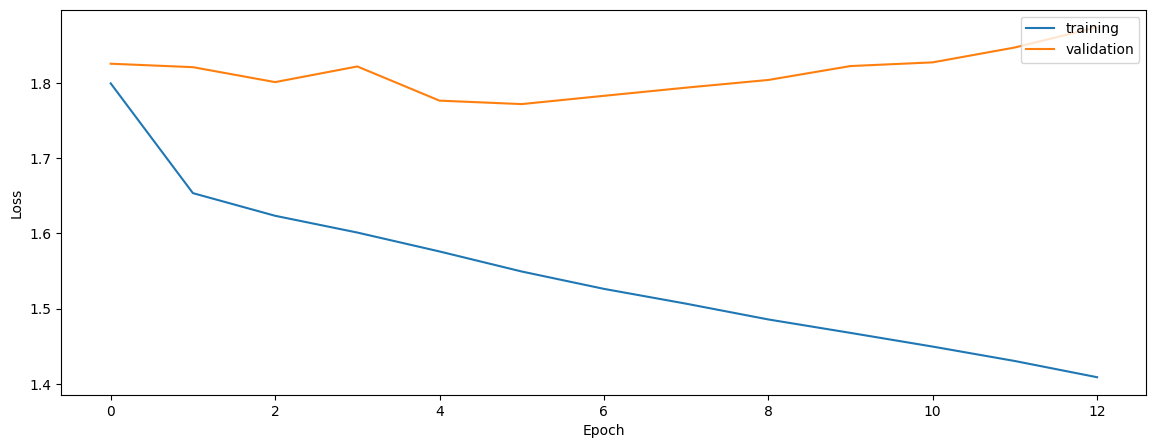

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.39201169117735996
0.3234329915498763
0.3473557538437904


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4511462853828547
0.450240992414665
0.4248442682630855


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4503997881753834
0.4495057549085985
0.4258051659045869


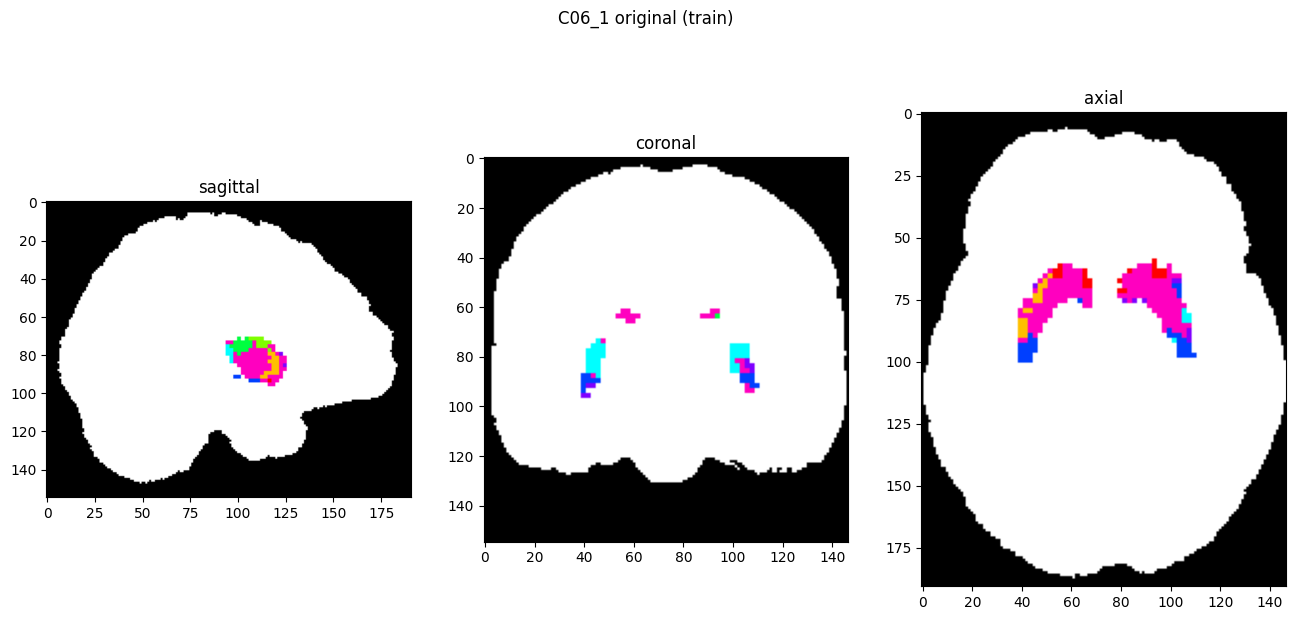

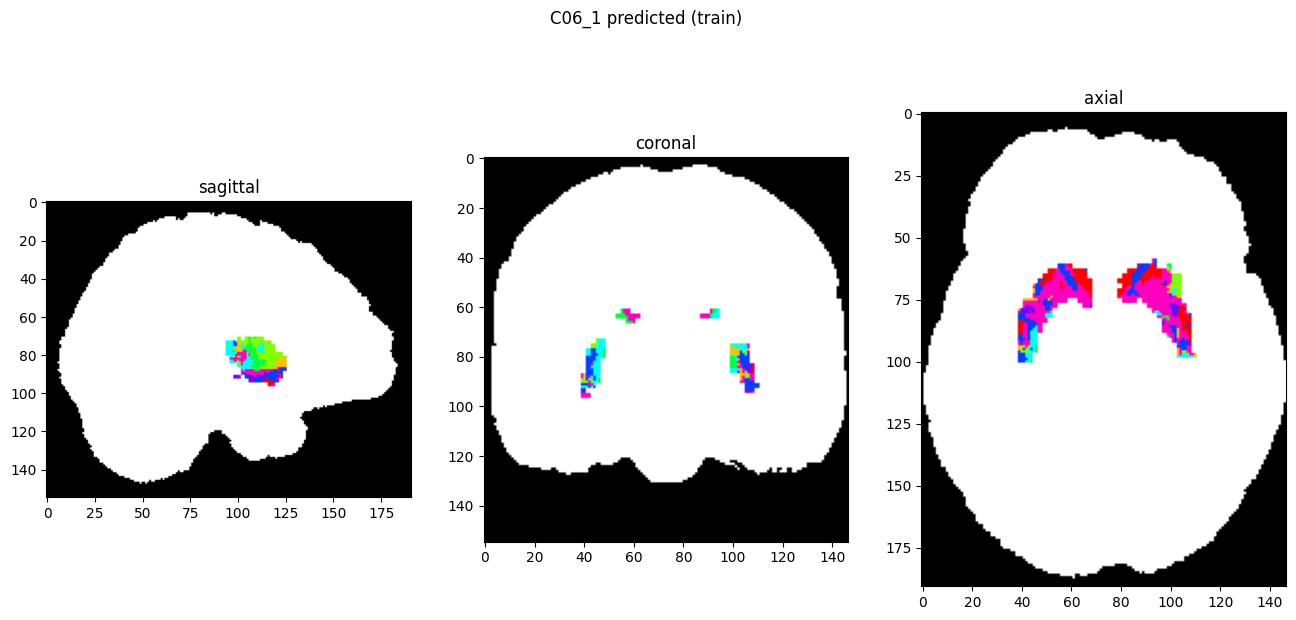

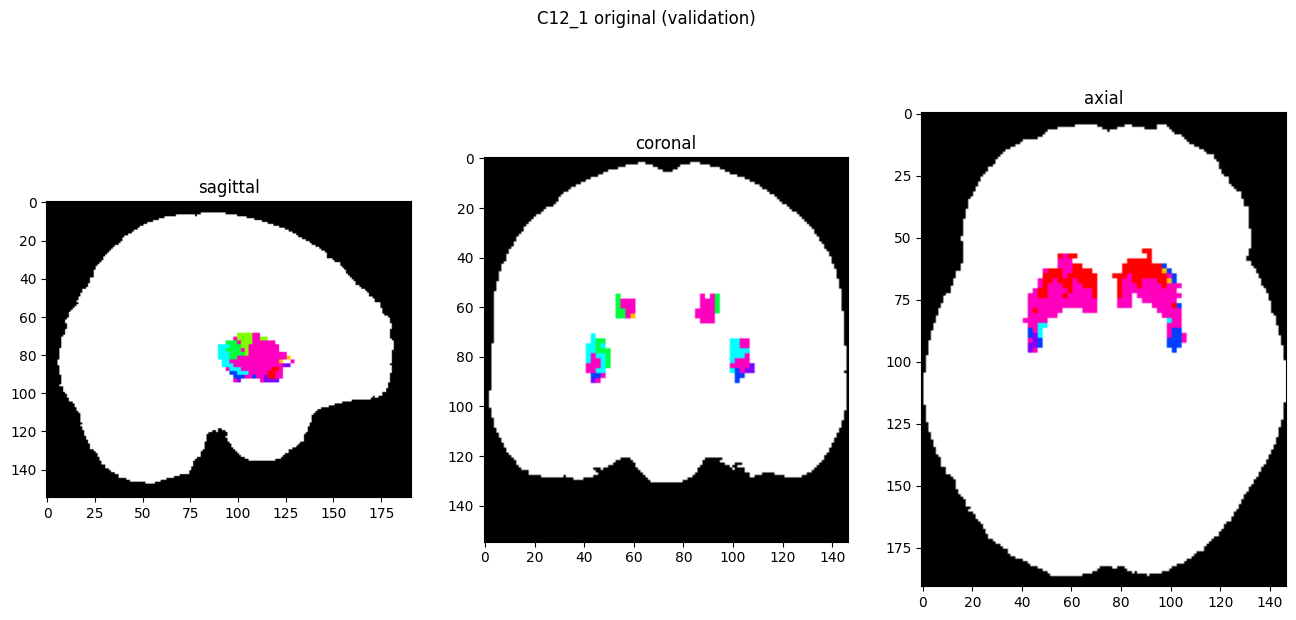

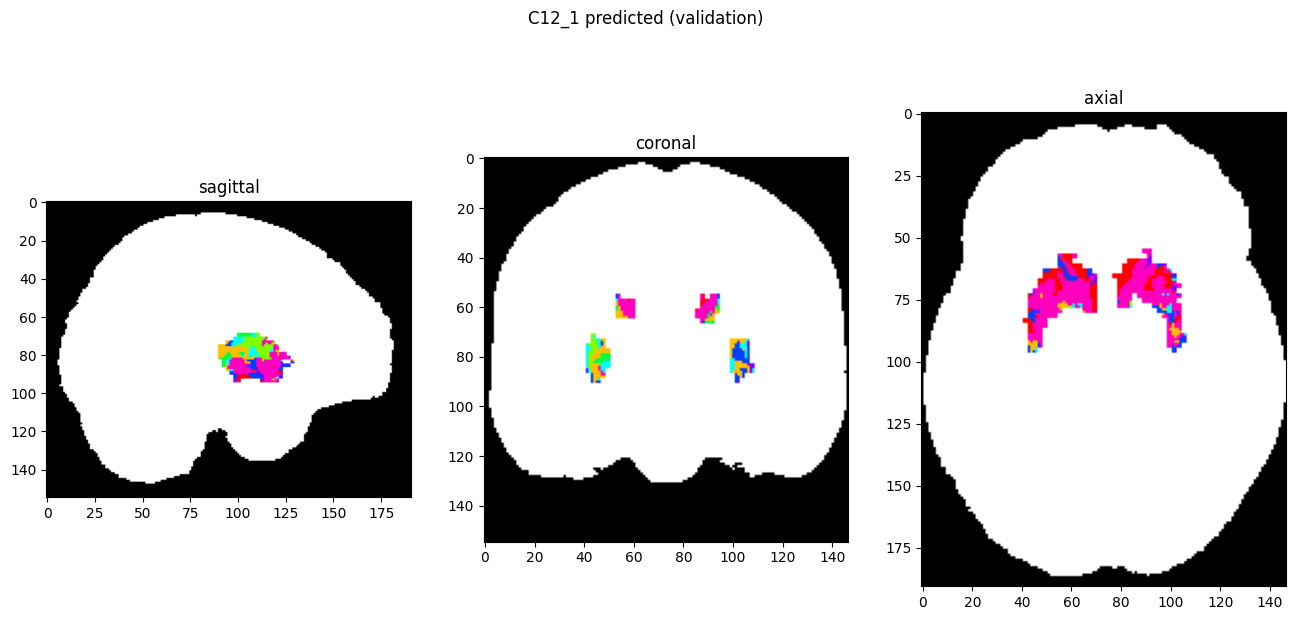

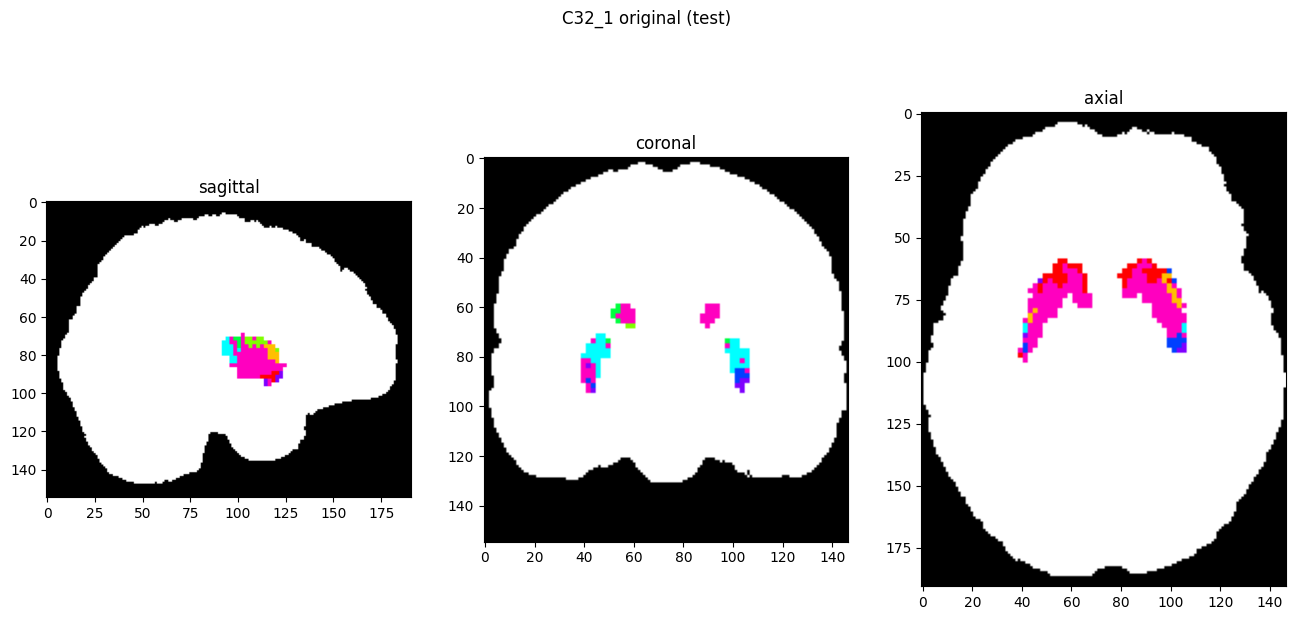

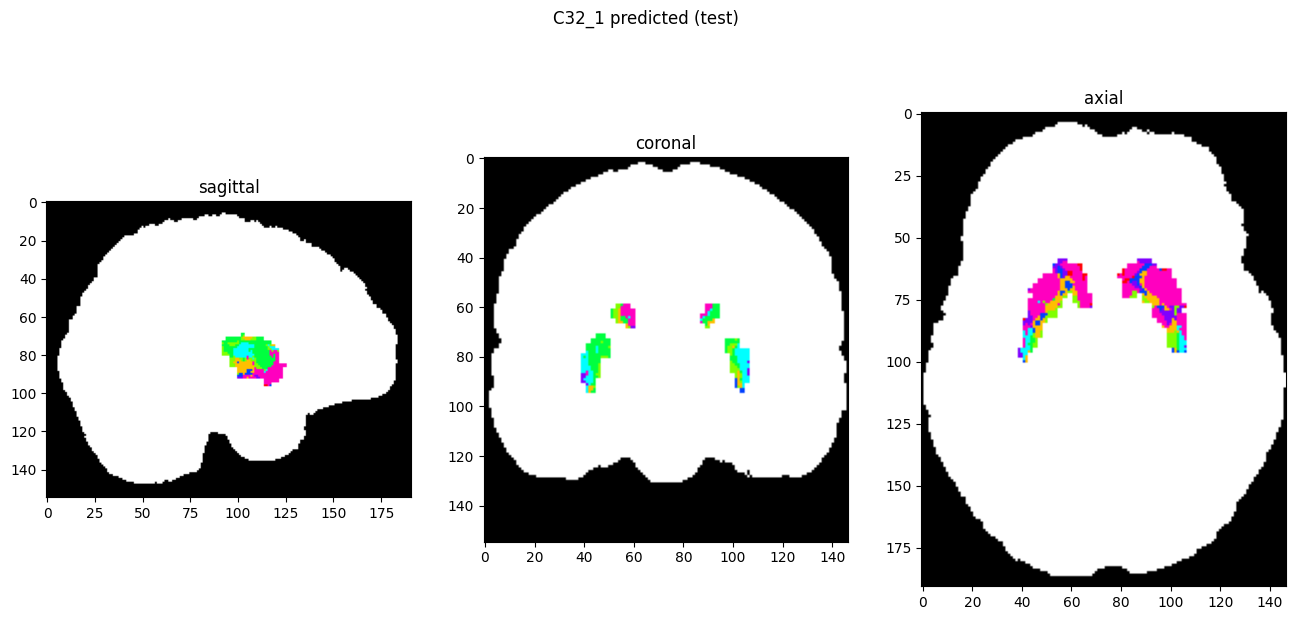

In [10]:
showResults(model, gen, threshold=0)